# Mid-Term Project

#### Overview
- Use Medicare CCLF Claims from Syntegra dataset to answer key business questions
- Extra credit for building up on the questions below (additional questions + answers)
- One Jupyter notebook solution with clear Python code and all cell outputs available
- At least two data quality checks

## Step 0. Prepare raw input datasets

Here we will 1) load original datasets, 2) remove unused columns, 3) de-duplicate rows, and 4) join datasets, not necessarily in this order

Assumptions: 
- Claim ID (cur_clm_uniq_id) represents one claim, which may or may not have more than one code (code could be HCPCS/CPT, diagnosis, procedure...)
- There is a one-to-many relationship between patient IDs (bene_mbi_id) and claim IDs (cur_clm_uniq_id), i.e. each claim is unique to one patient, but one patient can have more than one claim

### 0.1 Import required packages

In [316]:
import numpy as np
import pandas as pd

In [317]:
# Turn off the automatic setting that redacts the columns/rows from the dataframe output
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 200)

### 0.2 Load & select columns to be used from raw (original) datasets

### 0.2.1 Load & select columns from Claims Header dataset

In [320]:
# Load Claims Header dataset
parta_claims_header_raw_df = pd.read_csv("/Users/rithin/Downloads/Syntegra data/parta_claims_header.csv")
parta_claims_header_raw_df.sort_values(by=['cur_clm_uniq_id'])

,cur_clm_uniq_id,prvdr_oscar_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_from_dt,clm_thru_dt,clm_bill_fac_type_cd,clm_bill_clsfctn_cd,prncpl_dgns_cd,admtg_dgns_cd,clm_mdcr_npmt_rsn_cd,clm_pmt_amt,clm_nch_prmry_pyr_cd,prvdr_fac_fips_st_cd,bene_ptnt_stus_cd,dgns_drg_cd,clm_op_srvc_type_cd,fac_prvdr_npi_num,oprtg_prvdr_npi_num,atndg_prvdr_npi_num,othr_prvdr_npi_num,clm_adjsmt_type_cd,clm_efctv_dt,clm_idr_ld_dt,bene_eqtbl_bic_hicn_num,clm_admsn_type_cd,clm_admsn_src_cd,clm_bill_freq_cd,clm_query_cd,dgns_prcdr_icd_ind,clm_mdcr_instnl_tot_chrg_amt,clm_mdcr_ip_pps_cptl_ime_amt,clm_oprtnl_ime_amt,clm_mdcr_ip_pps_dsprprtnt_amt,clm_hipps_uncompd_care_amt,clm_oprtnl_dsprtnt_amt
510,100190,111821,1228,NaN,40,2018-06-10,2018-06-10,7,7,M1611,NaN,NaN,127.79,NaN,11,1,NaN,F,1780608992,NaN,1.972732e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,415.80,NaN,NaN,NaN,NaN,NaN
521,100402,100226,1261,NaN,60,2017-05-27,2017-06-02,1,1,K5733,K5733,NaN,10602.46,NaN,10,6,330.0,NaN,1689611501,NaN,1.285688e+09,NaN,NaN,NaN,NaN,NaN,1.0,1,1,3,0,70795.63,609.13,0.00,13.92,231.15,NaN
525,100464,360051,12978,NaN,40,2017-06-26,2017-06-26,1,3,R079,NaN,NaN,199.45,NaN,36,1,NaN,C,1073688354,NaN,1.982693e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,2709.80,NaN,NaN,NaN,NaN,NaN
536,100698,140276,11789,NaN,40,2017-07-28,2017-07-28,1,3,M545,NaN,NaN,85.25,NaN,14,1,NaN,C,1376521575,NaN,1.912991e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,115.00,NaN,NaN,NaN,NaN,NaN
540,100750,230216,12138,NaN,40,2018-01-13,2018-01-13,1,3,Z0289,NaN,N,0.00,NaN,23,9,NaN,C,1982685384,NaN,1.063442e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0,226.00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,1698691,390145,10007,NaN,40,2016-12-11,2016-12-11,1,3,Z01818,NaN,NaN,43.01,NaN,39,1,NaN,C,1689691214,NaN,1.679505e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,235.00,NaN,NaN,NaN,NaN,NaN
4365,1698722,200021,10985,NaN,40,2018-06-16,2018-06-16,1,3,E782,NaN,NaN,179.09,NaN,20,1,NaN,C,1932164795,NaN,1.548289e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,1939.35,NaN,NaN,NaN,NaN,NaN
4366,1698935,210022,1297,NaN,40,2018-04-06,2018-04-06,1,3,I110,NaN,NaN,400.81,NaN,21,9,NaN,C,1205896446,NaN,1.922016e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,554.00,NaN,NaN,NaN,NaN,NaN
4367,1699005,100057,12194,NaN,40,2016-04-27,2016-04-27,1,3,I348,NaN,NaN,265.19,NaN,10,1,NaN,C,1821019571,NaN,1.437130e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,8423.00,NaN,NaN,NaN,NaN,NaN


#### Data Quality Check #1: If true, the original dataset was unique on claim ID

In [322]:
parta_claims_header_raw_df_count = parta_claims_header_raw_df.shape[0]
parta_claims_header_raw_uniq_clm_id_df = parta_claims_header_raw_df['cur_clm_uniq_id'].drop_duplicates()

parta_claims_header_raw_df_count == parta_claims_header_raw_uniq_clm_id_df.shape[0]

True

In [323]:
# Select only the desired columns (renaming if needed) and remove duplicates if any
parta_claims_header_df = parta_claims_header_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'atndg_prvdr_npi_num', 
    'clm_from_dt', 'prncpl_dgns_cd', 'clm_pmt_amt'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'clm_from_dt': 'claim_date',
        'atndg_prvdr_npi_num': 'npi_id'
    }
)
parta_claims_header_df

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,clm_pmt_amt
0,1001595,10226,1.366492e+09,2018-02-28,M25551,259.01
1,1004555,10133,1.942275e+09,2018-11-02,Z9861,29.56
2,1011605,10163,1.578546e+09,2018-01-02,C439,45.88
3,1011758,1003,1.952368e+09,2018-06-12,R310,9.40
4,101424,10052,1.336125e+09,2016-04-13,L821,34.18
...,...,...,...,...,...,...
8621,999774,10367,NaN,2017-11-06,R072,374.08
8622,999808,10496,1.740225e+09,2017-07-19,R079,360.89
8623,999878,12160,1.497784e+09,2018-01-18,R5383,90.73
8624,999961,12090,1.083691e+09,2018-03-10,C73,329.44


#### Data Quality Check #2: If true, the filtered dataset did not have any duplicates

In [325]:
parta_claims_header_df_count = parta_claims_header_df.shape[0]

parta_claims_header_raw_df_count == parta_claims_header_df_count

True

#### Data Quality Check #3: If the resulting dataframe is empty, it means all the records have diagnosis code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [327]:
parta_claims_header_df.loc[~parta_claims_header_df.prncpl_dgns_cd.notnull()]

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,clm_pmt_amt


### 0.2.2 Load & select columns from Claims Revenue Center dataset

In [329]:
# Load Claims Revenue Center dataset
# Note this dataset has more than one record for each claim ID (cur_clm_uniq_id)
# Also note there are two sets of date columns, 
#  one for claim ID (clm_from/thru_dt) and one for claim line (clm_line_from/thru_dt)
parta_claims_revenue_center_detail_raw_df = pd.read_csv(
    "/Users/rithin/Downloads/Syntegra data/parta_claims_revenue_center_detail.csv",low_memory=False
)
parta_claims_revenue_center_detail_raw_df.sort_values(by=['cur_clm_uniq_id'])

,cur_clm_uniq_id,clm_line_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_line_from_dt,clm_line_thru_dt,clm_line_prod_rev_ctr_cd,clm_line_instnl_rev_ctr_dt,clm_line_hcpcs_cd,bene_eqtbl_bic_hicn_num,prvdr_oscar_num,clm_from_dt,clm_thru_dt,clm_line_srvc_unit_qty,clm_line_cvrd_pd_amt,hcpcs_1_mdfr_cd,hcpcs_2_mdfr_cd,hcpcs_3_mdfr_cd,hcpcs_4_mdfr_cd,hcpcs_5_mdfr_cd,clm_rev_apc_hipps_cd
318,100073,1,12620,NaN,40,2018-12-02 00:00:00,2018-12-02 00:00:00,403,2018-12-02 00:00:00,77063,NaN,NaN,2018-12-02 00:00:00,2018-12-02 00:00:00,1,24.11,NaN,NaN,NaN,NaN,NaN,00000
383,100184,1,10080,NaN,40,2018-09-06 00:00:00,2018-09-06 00:00:00,1,NaN,NaN,NaN,NaN,2018-09-06 00:00:00,2018-09-06 00:00:00,0,0.00,NaN,NaN,NaN,NaN,NaN,00000
384,100190,1,1228,NaN,40,2018-06-10 00:00:00,2018-06-10 00:00:00,521,2018-06-10 00:00:00,G0467,NaN,NaN,2018-06-10 00:00:00,2018-06-10 00:00:00,1,133.74,NaN,NaN,NaN,NaN,NaN,00000
385,100190,2,1228,NaN,40,2018-06-10 00:00:00,2018-06-10 00:00:00,521,2018-06-10 00:00:00,98960,NaN,NaN,2018-06-10 00:00:00,2018-06-10 00:00:00,1,0.00,NaN,NaN,NaN,NaN,NaN,00000
386,100190,3,1228,NaN,40,2018-06-10 00:00:00,2018-06-10 00:00:00,521,2018-06-10 00:00:00,J1100,NaN,NaN,2018-06-10 00:00:00,2018-06-10 00:00:00,4,0.00,NaN,NaN,NaN,NaN,NaN,00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29896,1699197,2,1177,NaN,40,2016-05-22 00:00:00,2016-05-22 00:00:00,302,2016-05-22 00:00:00,86592,NaN,NaN,2016-05-22 00:00:00,2016-05-22 00:00:00,1,5.43,NaN,NaN,NaN,NaN,NaN,00000
29898,1699212,1,1262,NaN,60,2018-12-24 00:00:00,2018-12-25 00:00:00,730,NaN,NaN,NaN,NaN,2018-12-24 00:00:00,2018-12-25 00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,00000
29901,1699236,3,10580,NaN,40,2017-09-20 00:00:00,2017-09-20 00:00:00,370,2017-09-20 00:00:00,NaN,NaN,NaN,2017-09-20 00:00:00,2017-09-20 00:00:00,2,0.00,NaN,NaN,NaN,NaN,NaN,00000
29899,1699236,1,10580,NaN,40,2017-09-20 00:00:00,2017-09-20 00:00:00,258,2017-09-20 00:00:00,NaN,NaN,NaN,2017-09-20 00:00:00,2017-09-20 00:00:00,1,0.00,NaN,NaN,NaN,NaN,NaN,00000


#### Data Quality Check #4: If the resulting dataframe is empty, it means there is no difference between columns 'clm_line_from_dt' and 'clm_from_dt' for all the rows

In [331]:
parta_claims_revenue_center_detail_raw_df.loc[
    ~(parta_claims_revenue_center_detail_raw_df['clm_line_from_dt'] 
      == parta_claims_revenue_center_detail_raw_df['clm_from_dt'])
]

,cur_clm_uniq_id,clm_line_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_line_from_dt,clm_line_thru_dt,clm_line_prod_rev_ctr_cd,clm_line_instnl_rev_ctr_dt,clm_line_hcpcs_cd,bene_eqtbl_bic_hicn_num,prvdr_oscar_num,clm_from_dt,clm_thru_dt,clm_line_srvc_unit_qty,clm_line_cvrd_pd_amt,hcpcs_1_mdfr_cd,hcpcs_2_mdfr_cd,hcpcs_3_mdfr_cd,hcpcs_4_mdfr_cd,hcpcs_5_mdfr_cd,clm_rev_apc_hipps_cd


In [332]:
# Select only the desired columns (renaming if needed) and remove duplicates if any
# Select 'clm_from_dt' as the column for claim dates since we want uniqueness on claim ID, not claim line
parta_claims_revenue_center_detail_df = parta_claims_revenue_center_detail_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'clm_from_dt',
    'clm_line_hcpcs_cd', 'clm_line_cvrd_pd_amt'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'clm_from_dt': 'claim_date',
        'clm_line_hcpcs_cd': 'hcpcs_code'
    }
)
parta_claims_revenue_center_detail_df

,claim_id,patient_id,claim_date,hcpcs_code,clm_line_cvrd_pd_amt
0,1001122,10081,2018-05-30 00:00:00,NaN,0.00
1,1001595,10226,2018-02-28 00:00:00,G0283,9.67
7,1001595,10226,2018-02-28 00:00:00,G8978,0.00
8,1001595,10226,2018-02-28 00:00:00,G8979,0.00
10,1001595,10226,2018-02-28 00:00:00,97110,24.97
...,...,...,...,...,...
59414,999961,12090,2018-03-10 00:00:00,A9516,0.00
59415,999961,12090,2018-03-10 00:00:00,G8996,0.00
59416,999976,10768,2016-01-18 00:00:00,80053,11.37
59417,999976,10768,2016-01-18 00:00:00,80061,12.83


#### Data Quality Check #5: If the resulting dataframe is empty, it means all the records have HCPCS code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [334]:
parta_claims_revenue_center_detail_df.loc[
    ~parta_claims_revenue_center_detail_df.hcpcs_code.notnull()
]

,claim_id,patient_id,claim_date,hcpcs_code,clm_line_cvrd_pd_amt
0,1001122,10081,2018-05-30 00:00:00,NaN,0.0
25,1001595,10226,2018-02-28 00:00:00,NaN,0.0
29,1004555,10133,2018-11-02 00:00:00,NaN,0.0
30,1004904,10106,2018-02-26 00:00:00,NaN,0.0
32,100974,10042,2017-02-20 00:00:00,NaN,0.0
...,...,...,...,...,...
59369,999008,12473,2018-08-04 00:00:00,NaN,0.0
59402,999774,10367,2017-11-06 00:00:00,NaN,0.0
59407,999808,10496,2017-07-19 00:00:00,NaN,0.0
59410,999943,11021,2016-11-20 00:00:00,NaN,0.0


In [335]:
# Data Quality Check #5 failed, so remove rows with no HCPCS codes
parta_claims_revenue_center_detail_df = parta_claims_revenue_center_detail_df.loc[
    parta_claims_revenue_center_detail_df.hcpcs_code.notnull()
]

In [336]:
# Update date format for claim dates to match that of Claims Header dataset for easy join
parta_claims_revenue_center_detail_df.loc[:,'claim_date'] = pd.to_datetime(
    parta_claims_revenue_center_detail_df['claim_date']
).dt.strftime('%Y-%m-%d')
parta_claims_revenue_center_detail_df



,claim_id,patient_id,claim_date,hcpcs_code,clm_line_cvrd_pd_amt
1,1001595,10226,2018-02-28,G0283,9.67
7,1001595,10226,2018-02-28,G8978,0.00
8,1001595,10226,2018-02-28,G8979,0.00
10,1001595,10226,2018-02-28,97110,24.97
18,1001595,10226,2018-02-28,97140,20.33
...,...,...,...,...,...
59413,999961,12090,2018-03-10,78014,400.05
59414,999961,12090,2018-03-10,A9516,0.00
59415,999961,12090,2018-03-10,G8996,0.00
59416,999976,10768,2016-01-18,80053,11.37


#### Mini-Analysis #1: Find whether there are matching claims between Claim Header and Claims Revenue Center datasets

                                                ***

In [339]:
    claims_header_unique_claims_df = parta_claims_header_df[[
        'claim_id'
    ]].drop_duplicates()

    claims_header_unique_claims_df['header'] = 1

    revenue_center_unique_claims_df = parta_claims_revenue_center_detail_df[[
        'claim_id'
    ]].drop_duplicates()

    revenue_center_unique_claims_df['revenue'] = 1

    joined_df1 = pd.merge(
        claims_header_unique_claims_df,
        revenue_center_unique_claims_df,
        on='claim_id', how = 'outer'
    )
    joined_df1


,claim_id,header,revenue
0,100073,NaN,1.0
1,100190,1.0,1.0
2,100227,NaN,1.0
3,100402,1.0,NaN
4,100464,1.0,1.0
...,...,...,...
15721,1699137,NaN,1.0
15722,1699155,NaN,1.0
15723,1699195,NaN,1.0
15724,1699197,NaN,1.0


In [340]:
print('# of unique claims in Claims Header dataset: ' 
      + str(claims_header_unique_claims_df.shape[0])
     )
print('# of unique claims in Claims Revenue Center dataset: ' 
      + str(revenue_center_unique_claims_df.shape[0])
     )

# of unique claims in Claims Header dataset: 8626
# of unique claims in Claims Revenue Center dataset: 13406


In [341]:
print('# of unique claims in Claims Header and Claims Revenue Center datasets combined: ' 
      + str(joined_df1.shape[0])
     )
print('From combined list of unique claims - ')
print('# of unique claims in only Claims Header dataset: ' 
      + str(joined_df1.loc[(joined_df1.header == 1) & ~(joined_df1.revenue == 1)].shape[0])
     )
print('# of unique claims in only Claims Revenue Center dataset: ' 
      + str(joined_df1.loc[~(joined_df1.header == 1) & (joined_df1.revenue == 1)].shape[0])
     )
print('# of unique claims in both Claims Header AND Claims Revenue Center datasets: ' 
      + str(joined_df1.loc[(joined_df1.header == 1) & (joined_df1.revenue == 1)].shape[0])
     )

# of unique claims in Claims Header and Claims Revenue Center datasets combined: 15726
From combined list of unique claims - 
# of unique claims in only Claims Header dataset: 2320
# of unique claims in only Claims Revenue Center dataset: 7100
# of unique claims in both Claims Header AND Claims Revenue Center datasets: 6306


Conclusion: There are quite a number of claims available in both datasets, so join them on claim ID as an outer join to get all possible claims without duplicates

                                                ***

### 0.2.3 Load & select columns from Diagnosis dataset

In [345]:
# Load the Diagnosis dataset
# Note that 'clm_from_dt' has some records with null values, but we need claim dates for all claims
parta_diagnosis_code_raw_df = pd.read_csv("/Users/rithin/Downloads/Syntegra data/parta_diagnosis_code.csv")
parta_diagnosis_code_raw_df.sort_values(by=['cur_clm_uniq_id', 'clm_val_sqnc_num'])

,cur_clm_uniq_id,bene_mbi_id,bene_hic_num,clm_type_cd,clm_prod_type_cd,clm_val_sqnc_num,clm_dgns_cd,bene_eqtbl_bic_hicn_num,prvdr_oscar_num,clm_from_dt,clm_thru_dt,clm_poa_ind,dgns_prcdr_icd_ind
244,100190,1228,NaN,40,NaN,1,M1611,NaN,NaN,NaN,2018-06-10 00:00:00,NaN,0
243,100190,1228,NaN,40,NaN,2,M25572,NaN,NaN,NaN,2018-06-10 00:00:00,NaN,0
246,100190,1228,NaN,40,NaN,3,M25551,NaN,NaN,NaN,2018-06-10 00:00:00,NaN,0
245,100190,1228,NaN,40,NaN,4,M5136,NaN,NaN,NaN,2018-06-10 00:00:00,NaN,0
366,100402,1261,NaN,60,NaN,11,E119,NaN,100256.0,2017-05-28 00:00:00,2017-06-02 00:00:00,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16232,1699102,11842,NaN,60,NaN,13,Z8673,NaN,330191.0,2017-01-31 00:00:00,2017-02-03 00:00:00,0,0
16236,1699137,10873,NaN,40,NaN,1,N390,NaN,NaN,NaN,2018-07-12 00:00:00,NaN,0
16235,1699137,10873,NaN,40,NaN,2,N390,NaN,NaN,NaN,2018-07-12 00:00:00,NaN,0
16237,1699155,11689,NaN,40,NaN,3,K219,NaN,NaN,NaN,2018-12-06 00:00:00,NaN,0


In [346]:
# Select only the desired columns (renaming if needed) and remove duplicates if any
# Use 'clm_thru_dt' as claim date columns since 'clm_from_dt' has some nulls
parta_diagnosis_code_df = parta_diagnosis_code_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'clm_thru_dt', 'clm_dgns_cd'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'clm_thru_dt': 'claim_date'
    }
)
parta_diagnosis_code_df

,claim_id,patient_id,claim_date,clm_dgns_cd
0,1001122,10081,2018-05-30 00:00:00,K5289
1,1001595,10226,2018-02-28 00:00:00,M25551
2,1001595,10226,2018-02-28 00:00:00,M79604
3,1001865,10133,2018-09-14 00:00:00,G459
4,1004555,10133,2018-11-02 00:00:00,Z9861
...,...,...,...,...
32047,999878,12160,2018-01-18 00:00:00,N390
32048,999943,11021,2016-11-20 00:00:00,M545
32049,999961,12090,2018-03-10 00:00:00,C73
32050,999962,11030,2018-07-17 00:00:00,G8194


#### Data Quality Check #6: If the resulting dataframe is empty, it means all the records have values for 'clm_thru_dt' (if it's not empty it should be removed now since without claim dates it'd be difficult to use)

In [348]:
parta_diagnosis_code_df.loc[~parta_diagnosis_code_df.claim_date.notnull()]

,claim_id,patient_id,claim_date,clm_dgns_cd


#### Data Quality Check #7: If the resulting dataframe is empty, it means all the records have diagnosis code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [350]:
parta_diagnosis_code_df.loc[~parta_diagnosis_code_df.clm_dgns_cd.notnull()]

,claim_id,patient_id,claim_date,clm_dgns_cd


In [351]:
# Update date format for claim dates to match that of Claims Header dataset for easy join
parta_diagnosis_code_df['claim_date'] = pd.to_datetime(
    parta_diagnosis_code_df['claim_date']
).dt.strftime('%Y-%m-%d')
parta_diagnosis_code_df

,claim_id,patient_id,claim_date,clm_dgns_cd
0,1001122,10081,2018-05-30,K5289
1,1001595,10226,2018-02-28,M25551
2,1001595,10226,2018-02-28,M79604
3,1001865,10133,2018-09-14,G459
4,1004555,10133,2018-11-02,Z9861
...,...,...,...,...
32047,999878,12160,2018-01-18,N390
32048,999943,11021,2016-11-20,M545
32049,999961,12090,2018-03-10,C73
32050,999962,11030,2018-07-17,G8194


#### Mini-Analysis #2: Find whether there are matching claims between above two datasets and the Diagnosis dataset

                                                ***

In [354]:
diagnosis_unique_claims_df = parta_diagnosis_code_df[[
    'claim_id'
]].drop_duplicates()

diagnosis_unique_claims_df['diagnosis'] = 1

joined_df2 = pd.merge(
    joined_df1,
    diagnosis_unique_claims_df,
    on='claim_id', how = 'outer'
)
joined_df2

,claim_id,header,revenue,diagnosis
0,100073,NaN,1.0,NaN
1,100190,1.0,1.0,1.0
2,100227,NaN,1.0,NaN
3,100402,1.0,NaN,1.0
4,100464,1.0,1.0,1.0
...,...,...,...,...
19452,1699137,NaN,1.0,1.0
19453,1699155,NaN,1.0,1.0
19454,1699195,NaN,1.0,NaN
19455,1699197,NaN,1.0,NaN


In [355]:
print('# of unique claims in Claims Header+Claims Revenue Center datasets: ' 
      + str(joined_df1.shape[0])
     )
print('# of unique claims in Diagnosis dataset: ' 
      + str(diagnosis_unique_claims_df.shape[0])
     )

# of unique claims in Claims Header+Claims Revenue Center datasets: 15726
# of unique claims in Diagnosis dataset: 13432


In [356]:
print('# of unique claims in Claims Header+Claims Revenue Center and Diagnosis datasets combined: ' 
      + str(joined_df2.shape[0])
     )
print('From combined list of unique claims - ')
print('# of unique claims only in either Claims Header or Claims Revenue Center datasets: ' 
      + str(joined_df2.loc[
          ((joined_df2.header == 1) | (joined_df2.revenue == 1))
          & ~(joined_df2.diagnosis == 1)
      ].shape[0])
     )
print('# of unique claims in only Diagnosis dataset: ' 
      + str(joined_df2.loc[
          (~(joined_df2.header == 1) & ~(joined_df2.revenue == 1))
          & (joined_df2.diagnosis == 1)
      ].shape[0])
     )
print('# of unique claims in all three datasets: ' 
      + str(joined_df2.loc[
          (joined_df2.header == 1) & (joined_df2.revenue == 1) & (joined_df2.diagnosis == 1)
      ].shape[0])
     )

# of unique claims in Claims Header+Claims Revenue Center and Diagnosis datasets combined: 19457
From combined list of unique claims - 
# of unique claims only in either Claims Header or Claims Revenue Center datasets: 6025
# of unique claims in only Diagnosis dataset: 3731
# of unique claims in all three datasets: 5266


Conclusion: There are quite a number of claims available in all three datasets, so join diagnosis to the first two datasets on claim ID as an outer join to get all possible claims without duplicates

                                                ***

### 0.2.4 Load & select columns from Procedure dataset

In [360]:
# Load the Procedure dataset
parta_procedure_code_df = pd.read_csv("/Users/rithin/Downloads/Syntegra data/parta_procedure_code.csv")
parta_procedure_code_df

,cur_clm_uniq_id,bene_mbi_id,bene_hic_num,clm_type_cd,clm_val_sqnc_num,clm_prcdr_cd,clm_prcdr_prfrm_dt,bene_eqtbl_bic_hicn_num,prvdr_oscar_num,clm_from_dt,clm_thru_dt,dgns_prcdr_icd_ind
0,100402,1261,NaN,60,1,0DJD8ZZ,2017-05-31 00:00:00,NaN,100256,2017-05-28 00:00:00,2017-06-02 00:00:00,0
1,100402,1261,NaN,60,2,0D9670Z,2017-05-29 00:00:00,NaN,100256,2017-05-28 00:00:00,2017-06-02 00:00:00,0
2,100402,1261,NaN,60,3,0DJD8ZZ,2017-06-01 00:00:00,NaN,100256,2017-05-28 00:00:00,2017-06-02 00:00:00,0
3,100402,1261,NaN,60,4,0DB78ZX,2017-05-30 00:00:00,NaN,100256,2017-05-28 00:00:00,2017-06-02 00:00:00,0
4,1008371,1074,NaN,60,1,0T9B7ZZ,2016-12-03 00:00:00,NaN,140007,2016-12-02 00:00:00,2016-12-08 00:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
457,357821,10200,NaN,60,2,4A023N7,2018-06-18 00:00:00,NaN,100258,2018-06-16 00:00:00,2018-06-19 00:00:00,0
458,357821,10200,NaN,60,1,4A023N7,2018-06-18 00:00:00,NaN,100258,2018-06-16 00:00:00,2018-06-19 00:00:00,0
459,412998,10106,NaN,60,1,0SRC0J9,2016-12-09 00:00:00,NaN,250104,2016-12-09 00:00:00,2016-12-10 00:00:00,0
460,460114,10133,NaN,60,1,0QSH04Z,2018-05-17 00:00:00,NaN,150112,2018-05-07 00:00:00,2018-05-23 00:00:00,0


Conclusion: Don't join procedure dataset since the only useful info for sake of this analysis is the procedure codes and we won't be using them in our analysis

### 0.2.5 Load & select columns from DME dataset

In [363]:
# Load the DME dataset
partb_dme_raw_df = pd.read_csv("/Users/rithin/Downloads/Syntegra data/partb_dme.csv")
partb_dme_raw_df.sort_values(by='cur_clm_uniq_id')

,cur_clm_uniq_id,clm_line_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_from_dt,clm_thru_dt,clm_fed_type_srvc_cd,clm_pos_cd,clm_line_from_dt,clm_line_thru_dt,clm_line_hcpcs_cd,clm_line_cvrd_pd_amt,clm_prmry_pyr_cd,payto_prvdr_npi_num,ordrg_prvdr_npi_num,clm_carr_pmt_dnl_cd,clm_prcsg_ind_cd,clm_adjsmt_type_cd,clm_efctv_dt,clm_idr_ld_dt,clm_cntl_num,bene_eqtbl_bic_hicn_num,clm_line_alowd_chrg_amt,clm_disp_cd
267,100441,1,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,A4256,3.24,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,3.98,1
268,100441,2,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,E0607,59.80,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,76.54,1
269,100441,3,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,A4253,38.57,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,49.92,1
270,100441,4,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,A4259,4.20,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,4.80,1
271,100441,5,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,A4258,2.27,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,2.84,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,1696080,2,11689,NaN,82,2016-11-18,2016-11-18,P,12,2016-11-18,2016-11-18,A7038,0.00,NaN,1376599084,1.659342e+09,0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1
129,1696545,1,10046,NaN,82,2017-07-25,2017-07-25,R,12,2017-07-25,2017-07-25,E0570,6.30,NaN,1346347374,1.952397e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,8.12,1
1548,1696792,1,12086,NaN,82,2018-12-23,2018-12-23,P,12,2018-12-23,2018-12-23,A4604,35.58,NaN,1790823722,1.518936e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,48.17,1
1549,1697987,1,11074,NaN,82,2018-04-06,2018-04-06,P,12,2018-04-06,2018-04-06,A4253,27.92,NaN,1902842065,1.750382e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,33.28,1


In [364]:
# Select only the desired columns (rename columns if needed) and remove duplicates if any
partb_dme_df = partb_dme_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'ordrg_prvdr_npi_num',
    'clm_from_dt', 'clm_line_hcpcs_cd', 'clm_line_alowd_chrg_amt'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'ordrg_prvdr_npi_num': 'npi_id',
        'clm_from_dt': 'claim_date',
        'clm_line_hcpcs_cd': 'hcpcs_code',
        'clm_line_alowd_chrg_amt': 'claim_cost'
    }
)
partb_dme_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,claim_cost
0,1004024,10202,1.841430e+09,2016-07-18,E0601,41.91
1,1034063,10137,1.669460e+09,2016-04-22,E0601,62.46
2,1046877,10202,1.093713e+09,2016-02-03,E0601,29.31
3,1072934,10202,1.285602e+09,2016-08-15,E0601,27.82
4,1082554,10174,1.003895e+09,2016-08-30,E0431,18.75
...,...,...,...,...,...,...
2770,998097,10396,1.891706e+09,2016-12-06,A4253,69.69
2771,999226,1095,1.518066e+09,2017-12-28,A4256,3.68
2772,999226,1095,1.518066e+09,2017-12-28,A4253,49.92
2773,999226,1095,1.518066e+09,2017-12-28,A4259,4.26


#### Data Quality Check #8: If the resulting dataframe is empty, it means all the records have HCPCS code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [366]:
partb_dme_df.loc[~partb_dme_df.hcpcs_code.notnull()]

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,claim_cost


#### Mini-Analysis #3: Find whether there are matching claims between the first three datasets above and the DME dataset

                                                ***

In [369]:
dme_unique_claims_df = partb_dme_df[[
    'claim_id'
]].drop_duplicates()

dme_unique_claims_df['dme'] = 1

joined_df3 = pd.merge(
    joined_df2,
    dme_unique_claims_df,
    on='claim_id', how = 'outer'
)
joined_df3

,claim_id,header,revenue,diagnosis,dme
0,100073,NaN,1.0,NaN,NaN
1,100190,1.0,1.0,1.0,NaN
2,100227,NaN,1.0,NaN,NaN
3,100402,1.0,NaN,1.0,NaN
4,100441,NaN,NaN,NaN,1.0
...,...,...,...,...,...
20960,1699137,NaN,1.0,1.0,NaN
20961,1699155,NaN,1.0,1.0,NaN
20962,1699195,NaN,1.0,NaN,NaN
20963,1699197,NaN,1.0,NaN,NaN


In [370]:
print('# of unique claims in first three datasets: ' 
      + str(joined_df2.shape[0])
     )
print('# of unique claims in DME dataset: ' 
      + str(dme_unique_claims_df.shape[0])
     )

# of unique claims in first three datasets: 19457
# of unique claims in DME dataset: 1508


In [371]:
print('# of unique claims in the four datasets combined: ' 
      + str(joined_df3.shape[0])
     )
print('From combined list of unique claims - ')
print('# of unique claims in only the first three datasets: ' 
      + str(joined_df3.loc[
          ((joined_df3.header == 1) 
          | (joined_df3.revenue == 1)
          | (joined_df3.diagnosis == 1))
          & ~(joined_df3.dme == 1)
      ].shape[0])
     )
print('# of unique claims in only DME dataset: ' 
      + str(joined_df3.loc[
          ~(joined_df3.header == 1) 
          & ~(joined_df3.revenue == 1)
          & ~(joined_df3.diagnosis == 1)
          & (joined_df3.dme == 1)
      ].shape[0])
     )
print('# of unique claims in all four datasets: ' 
      + str(joined_df3.loc[
          (joined_df3.header == 1) 
          & (joined_df3.revenue == 1)
          & (joined_df3.diagnosis == 1)
          & (joined_df3.dme == 1)
      ].shape[0])
     )
print('# of unique claims in DME and any of the first three datasets: ' 
      + str(joined_df3.loc[
          ((joined_df3.header == 1) 
          | (joined_df3.revenue == 1)
          | (joined_df3.diagnosis == 1))
          & (joined_df3.dme == 1)
      ].shape[0])
     )

# of unique claims in the four datasets combined: 20965
From combined list of unique claims - 
# of unique claims in only the first three datasets: 19457
# of unique claims in only DME dataset: 1508
# of unique claims in all four datasets: 0
# of unique claims in DME and any of the first three datasets: 0


Conclusion: None of the claims from DME is in any of the first three datasets, so append them to the output after joining the first three datasets

                                                ***

### 0.2.6 Load & select columns from Physicians dataset

In [375]:
# Load the Physicians dataset
partb_physicians_raw_df = pd.read_csv("/Users/rithin/Downloads/Syntegra data/partb_physicians.csv")
partb_physicians_raw_df.sort_values(by='cur_clm_uniq_id')

,cur_clm_uniq_id,clm_line_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_from_dt,clm_thru_dt,rndrg_prvdr_type_cd,rndrg_prvdr_fips_st_cd,clm_prvdr_spclty_cd,clm_fed_type_srvc_cd,clm_pos_cd,clm_line_from_dt,clm_line_thru_dt,clm_line_hcpcs_cd,clm_line_cvrd_pd_amt,clm_line_prmry_pyr_cd,clm_line_dgns_cd,clm_rndrg_prvdr_tax_num,rndrg_prvdr_npi_num,clm_carr_pmt_dnl_cd,clm_prcsg_ind_cd,clm_adjsmt_type_cd,clm_efctv_dt,clm_idr_ld_dt,clm_cntl_num,bene_eqtbl_bic_hicn_num,clm_line_alowd_chrg_amt,clm_line_srvc_unit_qty,hcpcs_1_mdfr_cd,hcpcs_2_mdfr_cd,hcpcs_3_mdfr_cd,hcpcs_4_mdfr_cd,hcpcs_5_mdfr_cd,clm_disp_cd,clm_dgns_1_cd,clm_dgns_2_cd,clm_dgns_3_cd,clm_dgns_4_cd,clm_dgns_5_cd,clm_dgns_6_cd,clm_dgns_7_cd,clm_dgns_8_cd,dgns_prcdr_icd_ind,clm_dgns_9_cd,clm_dgns_10_cd,clm_dgns_11_cd,clm_dgns_12_cd,hcpcs_betos_cd
520,100020,1,1070,NaN,71,2016-10-04,2016-10-04,5,36,69,5,81,2016-10-04,2016-10-04,85610,5.10,NaN,I482,NaN,1.619972e+09,1,A,NaN,NaN,NaN,NaN,NaN,5.49,1.0,NaN,NaN,NaN,NaN,NaN,1,I482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,T1H
525,100024,1,11654,NaN,71,2016-12-10,2016-12-10,1,39,26,T,11,2016-12-10,2016-12-10,90834,61.17,NaN,F319,NaN,1.811965e+09,1,A,NaN,NaN,NaN,NaN,NaN,79.36,1.0,NaN,NaN,NaN,NaN,NaN,1,F319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,M5B
529,100030,1,12052,NaN,71,2017-04-15,2017-04-15,1,5,06,5,21,2017-04-15,2017-04-15,93010,6.92,NaN,R001,NaN,1.336344e+09,1,A,NaN,NaN,NaN,NaN,NaN,8.53,1.0,NaN,NaN,NaN,NaN,NaN,1,R001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,T2A
555,100038,1,12345,NaN,71,2018-07-02,2018-07-02,1,34,30,4,19,2018-07-02,2018-07-02,72158,89.30,NaN,M47816,NaN,1.295730e+09,1,A,NaN,NaN,NaN,NaN,NaN,112.57,1.0,26,NaN,NaN,NaN,NaN,1,M47816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,I2D
592,100061,1,10252,NaN,71,2016-07-04,2016-07-04,1,33,48,1,11,2016-07-04,2016-07-04,99213,65.83,NaN,L03032,NaN,1.861493e+09,1,A,NaN,NaN,NaN,NaN,NaN,82.36,1.0,NaN,NaN,NaN,NaN,NaN,1,L03032,B351,L853,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,M1B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5485,1699176,1,1008,NaN,71,2018-10-18,2018-10-18,1,18,29,1,21,2018-10-18,2018-10-18,99232,56.62,NaN,J9601,NaN,1.730182e+09,1,A,NaN,NaN,NaN,NaN,NaN,73.06,1.0,NaN,NaN,NaN,NaN,NaN,1,J9601,J810,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,M2B
66051,1699182,1,13175,NaN,71,2016-11-21,2016-11-21,5,31,69,5,81,2016-11-21,2016-11-21,80053,7.43,NaN,E782,NaN,1.063497e+09,1,A,NaN,NaN,NaN,NaN,NaN,7.87,1.0,NaN,NaN,NaN,NaN,NaN,1,E782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,T1B
66052,1699186,1,10710,NaN,71,2016-01-18,2016-01-18,1,14,30,4,23,2016-01-18,2016-01-18,73110,7.41,NaN,S52502A,NaN,1.427027e+09,1,A,NaN,NaN,NaN,NaN,NaN,8.97,1.0,26,LT,NaN,NaN,NaN,1,S52502A,S52602A,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,I1B
66053,1699204,1,11540,NaN,71,2018-05-08,2018-05-08,1,28,13,1,11,2018-05-08,2018-05-08,99214,80.42,NaN,M5116,NaN,1.275519e+09,1,A,NaN,NaN,NaN,NaN,NaN,101.91,1.0,NaN,NaN,NaN,NaN,NaN,1,M5116,M47816,M48061,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,M1B


In [376]:
#Possible expansio of analysis - keep as side note

partb_physicians_raw_df.groupby('clm_pos_cd').agg(
    uniq_clm_cnt=('cur_clm_uniq_id', 'nunique')
).sort_values(by='uniq_clm_cnt', ascending=False)

,uniq_clm_cnt
clm_pos_cd,
11,34209
81,17512
22,7218
21,6171
23,4505
24,1912
41,1619
19,1435
31,891


In [377]:
# Select only the desired columns and remove duplicates if any
partb_physicians_df = partb_physicians_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'rndrg_prvdr_npi_num', 'clm_from_dt', 
    'clm_line_hcpcs_cd', 'clm_line_dgns_cd', 'clm_line_alowd_chrg_amt'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'rndrg_prvdr_npi_num': 'npi_id',
        'clm_from_dt': 'claim_date',
        'clm_line_hcpcs_cd': 'hcpcs_code', 
        'clm_line_dgns_cd': 'diagnosis_code', 
        'clm_line_alowd_chrg_amt': 'claim_cost'
    }
)
partb_physicians_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost
0,100117,10046,1.073515e+09,2016-11-19,83861,H04123,0.00
1,1001777,10133,1.053398e+09,2016-12-15,99213,I480,69.50
2,1001907,10113,1.245238e+09,2017-02-09,11721,B351,43.37
3,1002867,10049,1.255316e+09,2017-09-23,88312,D0359,143.39
4,1002871,10026,1.265419e+09,2016-03-11,87086,N390,10.66
...,...,...,...,...,...,...,...
130694,999919,12345,1.962494e+09,2018-05-03,99214,E782,105.49
130695,999919,12345,1.962494e+09,2018-05-03,90732,Z23,108.14
130696,999919,12345,1.962494e+09,2018-05-03,G0009,Z23,19.91
130697,999959,11445,1.548250e+09,2016-09-24,66984,H2512,838.19


#### Data Quality Check #9: If the resulting dataframe is empty, it means all the records have HCPCS or diagnosis code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [379]:
partb_physicians_df.loc[
    (~partb_physicians_df.hcpcs_code.notnull()) | (~partb_physicians_df.diagnosis_code.notnull())
]

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost


#### Mini-Analysis #4: Find whether there are matching claims between above four datasets and the Physicians dataset

                                                ***

In [382]:
physicians_unique_claims_df = partb_physicians_df[[
    'claim_id'
]].drop_duplicates()

physicians_unique_claims_df['physicians'] = 1

joined_df4 = pd.merge(
    joined_df3,
    physicians_unique_claims_df,
    on='claim_id', how = 'outer'
)
joined_df4

,claim_id,header,revenue,diagnosis,dme,physicians
0,100020,NaN,NaN,NaN,NaN,1.0
1,100024,NaN,NaN,NaN,NaN,1.0
2,100030,NaN,NaN,NaN,NaN,1.0
3,100038,NaN,NaN,NaN,NaN,1.0
4,100061,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...
97953,1699195,NaN,1.0,NaN,NaN,NaN
97954,1699197,NaN,1.0,NaN,NaN,NaN
97955,1699204,NaN,NaN,NaN,NaN,1.0
97956,1699222,NaN,NaN,NaN,NaN,1.0


In [383]:
print('# of unique claims in first four datasets: ' 
      + str(joined_df3.shape[0])
     )
print('# of unique claims in Physicians dataset: ' 
      + str(physicians_unique_claims_df.shape[0])
     )

# of unique claims in first four datasets: 20965
# of unique claims in Physicians dataset: 76993


In [384]:
print('# of unique claims in the five datasets combined: ' 
      + str(joined_df4.shape[0])
     )
print('From combined list of unique claims - ')
print('# of unique claims in only the first four datasets: ' 
      + str(joined_df4.loc[
          ((joined_df4.header == 1) 
          | (joined_df4.revenue == 1)
          | (joined_df4.diagnosis == 1)
          | (joined_df4.dme == 1))
          & ~(joined_df4.physicians == 1)
      ].shape[0])
     )
print('# of unique claims in only Physicians dataset: ' 
      + str(joined_df4.loc[
          ~(joined_df4.header == 1) 
          & ~(joined_df4.revenue == 1)
          & ~(joined_df4.diagnosis == 1)
          & ~(joined_df4.dme == 1)
          & (joined_df4.physicians == 1)
      ].shape[0])
     )
print('# of unique claims in all five datasets: ' 
      + str(joined_df4.loc[
          (joined_df4.header == 1) 
          & (joined_df4.revenue == 1)
          & (joined_df4.diagnosis == 1)
          & (joined_df4.dme == 1)
          & (joined_df4.physicians == 1)
      ].shape[0])
     )
print('# of unique claims in Physicians and any of the first four datasets: ' 
      + str(joined_df4.loc[
          ((joined_df4.header == 1) 
          | (joined_df4.revenue == 1)
          | (joined_df4.diagnosis == 1)
          | (joined_df4.dme == 1))
          & (joined_df4.physicians == 1)
      ].shape[0])
     )

# of unique claims in the five datasets combined: 97958
From combined list of unique claims - 
# of unique claims in only the first four datasets: 20965
# of unique claims in only Physicians dataset: 76993
# of unique claims in all five datasets: 0
# of unique claims in Physicians and any of the first four datasets: 0


Conclusion: None of the claims from Physicians is in any of the first four datasets, so append them to the output after combining the first four datasets

                                                ***

### 0.2.7 Load & select columns from Patients dataset

In [388]:
# Load the Patients dataset
# For sake of simplicity in concept, beneficiary = patient
beneficiary_demographics_df = pd.read_csv("/Users/rithin/Downloads/Syntegra data/beneficiary_demographics.csv")
beneficiary_demographics_df

,bene_mbi_id,bene_member_month,bene_hic_num,bene_fips_state_cd,bene_fips_cnty_cd,bene_zip_cd,bene_dob,bene_sex_cd,bene_race_cd,bene_age,bene_mdcr_stus_cd,bene_dual_stus_cd,bene_death_dt,bene_rng_bgn_dt,bene_rng_end_dt,bene_1st_name,bene_midl_name,bene_last_name,bene_orgnl_entlmt_rsn_cd,bene_entlmt_buyin_ind,bene_part_a_enrlmt_bgn_dt,bene_part_b_enrlmt_bgn_dt,bene_line_1_adr,bene_line_2_adr,bene_line_3_adr,bene_line_4_adr,bene_line_5_adr,bene_line_6_adr,geo_zip_plc_name,geo_usps_state_cd,geo_zip5_cd,geo_zip4_cd
0,10,2016-01-01 00:00:00,NaN,55,79,NaN,1945-05-16 00:00:00,1,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,NaN,NaN
1,10,2016-02-01 00:00:00,NaN,55,79,NaN,1945-05-16 00:00:00,1,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,NaN,NaN
2,10,2016-03-01 00:00:00,NaN,55,79,NaN,1945-05-16 00:00:00,1,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,NaN,NaN
3,10,2016-04-01 00:00:00,NaN,55,79,NaN,1945-05-16 00:00:00,1,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,NaN,NaN
4,10,2016-05-01 00:00:00,NaN,55,79,NaN,1945-05-16 00:00:00,1,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31179,13380,2018-02-01 00:00:00,NaN,44,7,NaN,1947-03-31 00:00:00,2,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,NaN,NaN
31180,13380,2018-03-01 00:00:00,NaN,44,7,NaN,1947-03-31 00:00:00,2,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,NaN,NaN
31181,13380,2018-04-01 00:00:00,NaN,44,7,NaN,1947-03-31 00:00:00,2,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,NaN,NaN
31182,13380,2018-05-01 00:00:00,NaN,44,7,NaN,1947-03-31 00:00:00,2,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,NaN,NaN


In [389]:
# Select only the desired columns (rename columns if needed) and remove duplicates if any
beneficiary_demographics_df = beneficiary_demographics_df[[
    'bene_mbi_id', 'bene_dob', 'bene_sex_cd'
]].drop_duplicates().rename(
    columns={
        'bene_mbi_id': 'patient_id',
        'bene_dob': 'patient_birth_date'
    }
)
beneficiary_demographics_df

,patient_id,patient_birth_date,bene_sex_cd
0,10,1945-05-16 00:00:00,1
34,10007,1956-01-04 00:00:00,2
63,10010,1932-12-03 00:00:00,2
95,10013,1952-08-23 00:00:00,2
131,10017,1984-11-23 00:00:00,1
...,...,...,...
31037,13374,1948-07-11 00:00:00,2
31072,13376,1952-11-28 00:00:00,2
31103,13377,1956-01-16 00:00:00,1
31122,13379,1926-12-10 00:00:00,2


In [390]:
# Gender code as identified by the CMS CCLF resource (1 = male, 2 = female, 0 = Unknown = N/A)
# Convert gender code into readable acronym and drop original column
beneficiary_demographics_df['patient_gender'] = ''
beneficiary_demographics_df.loc[beneficiary_demographics_df.bene_sex_cd == 1, 'patient_gender'] = 'M'
beneficiary_demographics_df.loc[beneficiary_demographics_df.bene_sex_cd == 2, 'patient_gender'] = 'F'
beneficiary_demographics_df = beneficiary_demographics_df.drop('bene_sex_cd', axis=1)
beneficiary_demographics_df

,patient_id,patient_birth_date,patient_gender
0,10,1945-05-16 00:00:00,M
34,10007,1956-01-04 00:00:00,F
63,10010,1932-12-03 00:00:00,F
95,10013,1952-08-23 00:00:00,F
131,10017,1984-11-23 00:00:00,M
...,...,...,...
31037,13374,1948-07-11 00:00:00,F
31072,13376,1952-11-28 00:00:00,F
31103,13377,1956-01-16 00:00:00,M
31122,13379,1926-12-10 00:00:00,F


In [391]:
# Update date format for patient birth dates to match that of other date columns
beneficiary_demographics_df['patient_birth_date'] = pd.to_datetime(
    beneficiary_demographics_df['patient_birth_date']
).dt.strftime('%Y-%m-%d')
beneficiary_demographics_df

,patient_id,patient_birth_date,patient_gender
0,10,1945-05-16,M
34,10007,1956-01-04,F
63,10010,1932-12-03,F
95,10013,1952-08-23,F
131,10017,1984-11-23,M
...,...,...,...
31037,13374,1948-07-11,F
31072,13376,1952-11-28,F
31103,13377,1956-01-16,M
31122,13379,1926-12-10,F


#### Mini-Analysis #5: Find whether there are matching patients between the claims datasets and the Patients dataset

                                                ***

In [394]:
claims_header_unique_patients_df = parta_claims_header_df[[
    'patient_id'
]].drop_duplicates()

claims_header_unique_patients_df['header'] = 1

revenue_center_unique_patients_df = parta_claims_revenue_center_detail_df[[
    'patient_id'
]].drop_duplicates()

revenue_center_unique_patients_df['revenue'] = 1

diagnosis_unique_patients_df = parta_diagnosis_code_df[[
    'patient_id'
]].drop_duplicates()

diagnosis_unique_patients_df['diagnosis'] = 1

dme_unique_patients_df = partb_dme_df[[
    'patient_id'
]].drop_duplicates()

dme_unique_patients_df['dme'] = 1

physicians_unique_patients_df = partb_physicians_df[[
    'patient_id'
]].drop_duplicates()

physicians_unique_patients_df['physicians'] = 1

beneficiary_unique_patients_df = beneficiary_demographics_df[[
    'patient_id'
]].drop_duplicates()

beneficiary_unique_patients_df['beneficiary'] = 1

joined_patients_df = pd.merge(
    pd.merge(
        pd.merge(
            pd.merge(
                pd.merge(
                    claims_header_unique_patients_df,
                    revenue_center_unique_patients_df,
                    on='patient_id', how = 'outer'
                ),
                diagnosis_unique_patients_df,
                on='patient_id', how = 'outer'
            ),
            dme_unique_patients_df,
            on='patient_id', how = 'outer'
        ),
        physicians_unique_patients_df,
        on='patient_id', how = 'outer'
    ),
    beneficiary_unique_patients_df,
    on='patient_id', how = 'outer'
)

joined_patients_df

,patient_id,header,revenue,diagnosis,dme,physicians,beneficiary
0,10,1.0,1.0,1.0,NaN,1.0,1
1,12,NaN,NaN,NaN,NaN,NaN,1
2,13,1.0,1.0,1.0,1.0,1.0,1
3,102,1.0,1.0,1.0,NaN,1.0,1
4,109,1.0,1.0,1.0,NaN,1.0,1
...,...,...,...,...,...,...,...
995,13374,1.0,1.0,1.0,NaN,1.0,1
996,13376,1.0,1.0,1.0,NaN,1.0,1
997,13377,1.0,1.0,1.0,1.0,1.0,1
998,13379,NaN,NaN,NaN,NaN,1.0,1


In [395]:
print('# of unique patients in the five datasets combined: ' 
      + str(joined_patients_df.shape[0])
     )
print('From combined list of unique patients - ')
print('# of unique patients in only the claims datasets: ' 
      + str(joined_patients_df.loc[
          ((joined_patients_df.header == 1) 
          | (joined_patients_df.revenue == 1)
          | (joined_patients_df.diagnosis == 1)
          | (joined_patients_df.dme == 1)
          | (joined_patients_df.physicians == 1))
          & ~(joined_patients_df.beneficiary == 1)
      ].shape[0])
     )
print('# of unique patients in only Beneficiary dataset: ' 
      + str(joined_patients_df.loc[
          ~(joined_patients_df.header == 1) 
          & ~(joined_patients_df.revenue == 1)
          & ~(joined_patients_df.diagnosis == 1)
          & ~(joined_patients_df.dme == 1)
          & ~(joined_patients_df.physicians == 1)
          & (joined_patients_df.beneficiary == 1)
      ].shape[0])
     )
print('# of unique patients in all five datasets: ' 
      + str(joined_patients_df.loc[
          (joined_patients_df.header == 1) 
          & (joined_patients_df.revenue == 1)
          & (joined_patients_df.diagnosis == 1)
          & (joined_patients_df.dme == 1)
          & (joined_patients_df.physicians == 1)
          & (joined_patients_df.beneficiary == 1)
      ].shape[0])
     )
print('# of unique patients in Beneficiary and any of the claims datasets: ' 
      + str(joined_patients_df.loc[
          ((joined_patients_df.header == 1) 
          | (joined_patients_df.revenue == 1)
          | (joined_patients_df.diagnosis == 1)
          | (joined_patients_df.dme == 1)
          | (joined_patients_df.physicians == 1))
          & (joined_patients_df.beneficiary == 1)
      ].shape[0])
     )

# of unique patients in the five datasets combined: 1000
From combined list of unique patients - 
# of unique patients in only the claims datasets: 0
# of unique patients in only Beneficiary dataset: 38
# of unique patients in all five datasets: 276
# of unique patients in Beneficiary and any of the claims datasets: 962


Conclusion: Most of the patients have some claims, so we can join the beneficiary dataset to the claims to get some of the patient demographics, i.e. age and gender

                                                ***

### 0.3 Combine all datasets

### 0.3.1. Join datasets with common records

In [400]:
# Join Claims Header and Claims Revenue Center datasets on claim ID, patient ID, and claim date
# Perform outer join to capture all possible claims
medicare_df = pd.merge(
    parta_claims_header_df,
    parta_claims_revenue_center_detail_df,
    on=['claim_id','patient_id','claim_date'], how='outer'
)

medicare_df.sort_values(by='claim_id')#.head(100)

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,clm_pmt_amt,hcpcs_code,clm_line_cvrd_pd_amt
0,100073,12620,NaN,2018-12-02,NaN,NaN,77063,24.11
1,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,G0467,133.74
2,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,98960,0.00
3,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,J1100,0.00
4,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,J1885,0.00
...,...,...,...,...,...,...,...,...
38387,1699195,10958,NaN,2017-04-19,NaN,NaN,88342,0.00
38390,1699195,10958,NaN,2017-04-19,NaN,NaN,J2250,0.00
38392,1699197,1177,NaN,2016-05-22,NaN,NaN,86592,5.43
38391,1699197,1177,NaN,2016-05-22,NaN,NaN,36415,0.00


In [401]:
#Data cleaning checks 1
# Check for duplicate claim IDs
duplicates_check = medicare_df[medicare_df.duplicated(subset=['claim_id'], keep=False)]
if not duplicates_check.empty:
        print("Warning: Duplicate claim IDs found!")
        print(duplicates_check)
    

       claim_id  patient_id        npi_id  claim_date prncpl_dgns_cd  \
1        100190        1228  1.972732e+09  2018-06-10          M1611   
2        100190        1228  1.972732e+09  2018-06-10          M1611   
3        100190        1228  1.972732e+09  2018-06-10          M1611   
4        100190        1228  1.972732e+09  2018-06-10          M1611   
5        100190        1228  1.972732e+09  2018-06-10          M1611   
...         ...         ...           ...         ...            ...   
38388   1699195       10958           NaN  2017-04-19            NaN   
38389   1699195       10958           NaN  2017-04-19            NaN   
38390   1699195       10958           NaN  2017-04-19            NaN   
38391   1699197        1177           NaN  2016-05-22            NaN   
38392   1699197        1177           NaN  2016-05-22            NaN   

       clm_pmt_amt hcpcs_code  clm_line_cvrd_pd_amt  
1           127.79      G0467                133.74  
2           127.79      989

In [402]:
# Inspect duplicates in detail
duplicates_check = medicare_df[medicare_df.duplicated(subset=['claim_id'], keep=False)]
print(duplicates_check.head())

   claim_id  patient_id        npi_id  claim_date prncpl_dgns_cd  clm_pmt_amt  \
1    100190        1228  1.972732e+09  2018-06-10          M1611       127.79   
2    100190        1228  1.972732e+09  2018-06-10          M1611       127.79   
3    100190        1228  1.972732e+09  2018-06-10          M1611       127.79   
4    100190        1228  1.972732e+09  2018-06-10          M1611       127.79   
5    100190        1228  1.972732e+09  2018-06-10          M1611       127.79   

  hcpcs_code  clm_line_cvrd_pd_amt  
1      G0467                133.74  
2      98960                  0.00  
3      J1100                  0.00  
4      J1885                  0.00  
5      J2270                  0.00  


In [403]:
#Data cleaning checks 2
# Aggregate duplicates by claim_id
aggregated_claims_df = medicare_df.groupby('claim_id', as_index=False).agg({
    'patient_id': 'first',                       # patient_id is the same across duplicates
    'npi_id': 'first',                           # npi_id is the same across duplicates
    'claim_date': 'first',                       # claim_date is the same across duplicates
    'hcpcs_code': lambda x: ','.join(x.dropna().astype(str).unique()),   # Concatenate unique HCPCS codes, handling NaNs
    'prncpl_dgns_cd': lambda x: ','.join(x.dropna().astype(str).unique()), # Concatenate unique diagnosis codes, handling NaNs
    'clm_pmt_amt': 'sum'                          # Sum the claim costs for each line item
})

# Display the aggregated data
print(aggregated_claims_df.head())

# Remove exact duplicates
medicare_df = medicare_df.drop_duplicates()

# Sort by date and drop duplicates, keeping the latest entry
medicare_df = medicare_df.sort_values(by=['claim_id', 'claim_date']).drop_duplicates(subset='claim_id', keep='last')

# Flag duplicate claim_id rows for further investigation
medicare_df['is_duplicate'] = medicare_df.duplicated(subset=['claim_id'], keep=False)
duplicates_for_review = medicare_df[medicare_df['is_duplicate'] == True]


   claim_id  patient_id        npi_id  claim_date  \
0    100073       12620           NaN  2018-12-02   
1    100190        1228  1.972732e+09  2018-06-10   
2    100227       12140           NaN  2018-10-24   
3    100402        1261  1.285688e+09  2017-05-27   
4    100464       12978  1.982693e+09  2017-06-26   

                            hcpcs_code prncpl_dgns_cd  clm_pmt_amt  
0                                77063                        0.00  
1  G0467,98960,J1100,J1885,J2270,99213          M1611       766.74  
2                                J2785                        0.00  
3                                               K5733     10602.46  
4                                74230           R079       199.45  


In [404]:
# Since Claims Header dataset records the amount Medicare paid for the claims 
#  and Claims Revenue Center dataset records the amount Medicare reimbursed the provider,
#  assume they were separate charges and add them to get the total cost for claim (for particular code)
# Once the costs are combined into one column, remove the older columns and any duplicates
medicare_df['claim_cost'] = medicare_df['clm_pmt_amt']+medicare_df['clm_line_cvrd_pd_amt']
medicare_df = medicare_df.drop(['clm_pmt_amt', 'clm_line_cvrd_pd_amt'], axis=1).drop_duplicates()
medicare_df.sort_values(by='claim_id').head(20)

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,hcpcs_code,is_duplicate,claim_cost
0,100073,12620,NaN,2018-12-02,NaN,77063,False,NaN
6,100190,1228,1.972732e+09,2018-06-10,M1611,99213,False,127.79
7,100227,12140,NaN,2018-10-24,NaN,J2785,False,NaN
8,100402,1261,1.285688e+09,2017-05-27,K5733,NaN,False,NaN
9,100464,12978,1.982693e+09,2017-06-26,R079,74230,False,282.62
10,100698,11789,1.912991e+09,2017-07-28,M545,G0463,False,170.30
11,100750,12138,1.063442e+09,2018-01-13,Z0289,NaN,False,NaN
12,100974,10042,NaN,2017-02-20,NaN,G0202,False,NaN
13,100982,12086,1.902839e+09,2018-06-23,G4733,95811,False,1441.39
14,101001,11663,1.932133e+09,2016-11-08,R918,71020,False,98.85


In [405]:
claims_header_revenue_diagnosis_df_count = medicare_df.shape[0]

### 0.3.2 Append datasets with no common records

In [407]:
# Create a dummy column for diagnosis code in DME dataset before appending so the list of columns match
partb_dme_df['diagnosis_code'] = np.nan
partb_dme_df = partb_dme_df[[
    'claim_id', 'patient_id', 'npi_id', 'claim_date', 'hcpcs_code', 'diagnosis_code', 'claim_cost'
]]
partb_dme_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost
0,1004024,10202,1.841430e+09,2016-07-18,E0601,NaN,41.91
1,1034063,10137,1.669460e+09,2016-04-22,E0601,NaN,62.46
2,1046877,10202,1.093713e+09,2016-02-03,E0601,NaN,29.31
3,1072934,10202,1.285602e+09,2016-08-15,E0601,NaN,27.82
4,1082554,10174,1.003895e+09,2016-08-30,E0431,NaN,18.75
...,...,...,...,...,...,...,...
2770,998097,10396,1.891706e+09,2016-12-06,A4253,NaN,69.69
2771,999226,1095,1.518066e+09,2017-12-28,A4256,NaN,3.68
2772,999226,1095,1.518066e+09,2017-12-28,A4253,NaN,49.92
2773,999226,1095,1.518066e+09,2017-12-28,A4259,NaN,4.26


In [408]:
# Append DME dataset to the first three claims datasets
medicare_df = pd.concat([medicare_df, partb_dme_df])
medicare_df

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,hcpcs_code,is_duplicate,claim_cost,diagnosis_code
0,100073,12620,NaN,2018-12-02,NaN,77063,False,NaN,NaN
6,100190,1228,1.972732e+09,2018-06-10,M1611,99213,False,127.79,NaN
7,100227,12140,NaN,2018-10-24,NaN,J2785,False,NaN,NaN
8,100402,1261,1.285688e+09,2017-05-27,K5733,NaN,False,NaN,NaN
9,100464,12978,1.982693e+09,2017-06-26,R079,74230,False,282.62,NaN
...,...,...,...,...,...,...,...,...,...
2770,998097,10396,1.891706e+09,2016-12-06,NaN,A4253,NaN,69.69,NaN
2771,999226,1095,1.518066e+09,2017-12-28,NaN,A4256,NaN,3.68,NaN
2772,999226,1095,1.518066e+09,2017-12-28,NaN,A4253,NaN,49.92,NaN
2773,999226,1095,1.518066e+09,2017-12-28,NaN,A4259,NaN,4.26,NaN


In [409]:
claims_header_revenue_diagnosis_dme_df_count = medicare_df.shape[0]



In [410]:
partb_dme_df_count = partb_dme_df.shape[0]
claims_w_dme_df_count = medicare_df.shape[0]

print('Claim count for Claims Header + Revenue Center + Diagnosis: ' 
      + str(claims_header_revenue_diagnosis_df_count))
print('Claim count for DME: ' + str(partb_dme_df_count))
print('Expected claim count after appending DME dataset: ' 
     + str(claims_header_revenue_diagnosis_df_count+partb_dme_df_count))
print('Actual claim count after appending DME dataset: '
     + str(claims_w_dme_df_count))
print('Expected and actual claim count matches: '
     + str(claims_header_revenue_diagnosis_df_count+partb_dme_df_count == claims_w_dme_df_count))

Claim count for Claims Header + Revenue Center + Diagnosis: 15726
Claim count for DME: 2731
Expected claim count after appending DME dataset: 18457
Actual claim count after appending DME dataset: 18457
Expected and actual claim count matches: True


#### Data Quality Check #10: If True, we appended DME dataset to the first three claims datasets without any unexpected rows accruing

In [412]:
# Append Physicians dataset to the first four claims datasets
medicare_df = pd.concat([medicare_df, partb_physicians_df])
medicare_df

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,hcpcs_code,is_duplicate,claim_cost,diagnosis_code
0,100073,12620,NaN,2018-12-02,NaN,77063,False,NaN,NaN
6,100190,1228,1.972732e+09,2018-06-10,M1611,99213,False,127.79,NaN
7,100227,12140,NaN,2018-10-24,NaN,J2785,False,NaN,NaN
8,100402,1261,1.285688e+09,2017-05-27,K5733,NaN,False,NaN,NaN
9,100464,12978,1.982693e+09,2017-06-26,R079,74230,False,282.62,NaN
...,...,...,...,...,...,...,...,...,...
130694,999919,12345,1.962494e+09,2018-05-03,NaN,99214,NaN,105.49,E782
130695,999919,12345,1.962494e+09,2018-05-03,NaN,90732,NaN,108.14,Z23
130696,999919,12345,1.962494e+09,2018-05-03,NaN,G0009,NaN,19.91,Z23
130697,999959,11445,1.548250e+09,2016-09-24,NaN,66984,NaN,838.19,H2512


#### Data Quality Check #11: If True, we appended Physicians dataset to the first four claims datasets without any unexpected rows accruing

In [414]:
partb_physicians_df_count = partb_physicians_df.shape[0]
claims_w_physicians_df_count = medicare_df.shape[0]

print('Claim count for Claims Header + Revenue Center + Diagnosis + DME: ' 
      + str(claims_header_revenue_diagnosis_dme_df_count))
print('Claim count for Physicians: ' + str(partb_physicians_df_count))
print('Expected claim count after appending Physicians dataset: ' 
     + str(claims_header_revenue_diagnosis_dme_df_count+partb_physicians_df_count))
print('Actual claim count after appending Physicians dataset: '
     + str(claims_w_physicians_df_count))
print('Expected and actual claim count matches: '
     + str(claims_header_revenue_diagnosis_dme_df_count+partb_physicians_df_count 
           == claims_w_physicians_df_count))

Claim count for Claims Header + Revenue Center + Diagnosis + DME: 18457
Claim count for Physicians: 128904
Expected claim count after appending Physicians dataset: 147361
Actual claim count after appending Physicians dataset: 147361
Expected and actual claim count matches: True


In [415]:
# Capture # records now to compare after joining patient details
medicare_claims_df_count = medicare_df.shape[0]

### 0.3.3 Join patient information

In [417]:
# Join claims data with patient details on patient ID
# Perform left join to only provide patient details for existing claims
medicare_df = pd.merge(
    medicare_df,
    beneficiary_demographics_df,
    on=['patient_id'], how='left'
)

medicare_df.sort_values(by='claim_id')#.head(100)

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,hcpcs_code,is_duplicate,claim_cost,diagnosis_code,patient_birth_date,patient_gender
18969,100020,1070,1.619972e+09,2016-10-04,NaN,85610,NaN,5.49,I482,1947-06-06,M
18974,100024,11654,1.811965e+09,2016-12-10,NaN,90834,NaN,79.36,F319,1977-11-08,M
18978,100030,12052,1.336344e+09,2017-04-15,NaN,93010,NaN,8.53,R001,1949-06-25,F
19004,100038,12345,1.295730e+09,2018-07-02,NaN,72158,NaN,112.57,M47816,1947-01-28,F
19039,100061,10252,1.861493e+09,2016-07-04,NaN,99213,NaN,82.36,L03032,1933-02-09,F
...,...,...,...,...,...,...,...,...,...,...,...
15723,1699195,10958,NaN,2017-04-19,NaN,J2250,False,NaN,NaN,1953-10-12,F
15724,1699197,1177,NaN,2016-05-22,NaN,86592,False,NaN,NaN,1948-09-07,M
83568,1699204,11540,1.275519e+09,2018-05-08,NaN,99214,NaN,101.91,M5116,1952-03-08,F
83569,1699222,11556,1.932188e+09,2016-03-16,NaN,J7060,NaN,10.66,I872,1955-02-04,F


In [418]:
#created this code in case of unintentional duplicates
#medicare_df = medicare_df.drop(
#    ['patient_birth_date_x', 'patient_birth_date_y', 
#    'patient_gender_x', 'patient_gender_y', 
#     'category_x', 'category_y'], 
#    axis=1, errors='ignore'
#)


In [419]:
print(medicare_df.columns)

Index(['claim_id', 'patient_id', 'npi_id', 'claim_date', 'prncpl_dgns_cd',
       'hcpcs_code', 'is_duplicate', 'claim_cost', 'diagnosis_code',
       'patient_birth_date', 'patient_gender'],
      dtype='object')


#### Data Quality Check #12: If True, we joined Patient dataset to the claims datasets without any unexpected rows accruing

In [421]:
# Check # records to ensure no extra records happened accidentally
medicare_claims_n_patient_info_df_count = medicare_df.shape[0]

print('Claims count before adding patient details: ' + str(medicare_claims_df_count))
print('Claims count after adding patient details: ' + str(medicare_claims_n_patient_info_df_count))
print('If True, no extra records were added accidentally from joining patient details into the claims: '
      + str(medicare_claims_df_count == medicare_claims_n_patient_info_df_count))

Claims count before adding patient details: 147361
Claims count after adding patient details: 147361
If True, no extra records were added accidentally from joining patient details into the claims: True


In [422]:
# Get claim year
medicare_df['claim_year'] = pd.to_datetime(
    medicare_df['claim_date']
).dt.strftime('%Y')
medicare_df

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,hcpcs_code,is_duplicate,claim_cost,diagnosis_code,patient_birth_date,patient_gender,claim_year
0,100073,12620,NaN,2018-12-02,NaN,77063,False,NaN,NaN,1936-04-20,F,2018
1,100190,1228,1.972732e+09,2018-06-10,M1611,99213,False,127.79,NaN,1954-10-09,F,2018
2,100227,12140,NaN,2018-10-24,NaN,J2785,False,NaN,NaN,1930-05-19,M,2018
3,100402,1261,1.285688e+09,2017-05-27,K5733,NaN,False,NaN,NaN,1934-06-19,F,2017
4,100464,12978,1.982693e+09,2017-06-26,R079,74230,False,282.62,NaN,1932-01-12,M,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
147356,999919,12345,1.962494e+09,2018-05-03,NaN,99214,NaN,105.49,E782,1947-01-28,F,2018
147357,999919,12345,1.962494e+09,2018-05-03,NaN,90732,NaN,108.14,Z23,1947-01-28,F,2018
147358,999919,12345,1.962494e+09,2018-05-03,NaN,G0009,NaN,19.91,Z23,1947-01-28,F,2018
147359,999959,11445,1.548250e+09,2016-09-24,NaN,66984,NaN,838.19,H2512,1945-04-03,F,2016


In [423]:
# Get patient age - subtract birthdate from claim date year to get the patient age at the time of claims
medicare_df['patient_birth_year'] = pd.to_datetime(
    medicare_df['patient_birth_date']
).dt.strftime('%Y')

medicare_df['patient_age'] = (
    medicare_df['claim_year'].astype('int') - medicare_df['patient_birth_year'].astype('int')
)

medicare_df = medicare_df.drop('patient_birth_year', axis=1)

medicare_df

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,hcpcs_code,is_duplicate,claim_cost,diagnosis_code,patient_birth_date,patient_gender,claim_year,patient_age
0,100073,12620,NaN,2018-12-02,NaN,77063,False,NaN,NaN,1936-04-20,F,2018,82
1,100190,1228,1.972732e+09,2018-06-10,M1611,99213,False,127.79,NaN,1954-10-09,F,2018,64
2,100227,12140,NaN,2018-10-24,NaN,J2785,False,NaN,NaN,1930-05-19,M,2018,88
3,100402,1261,1.285688e+09,2017-05-27,K5733,NaN,False,NaN,NaN,1934-06-19,F,2017,83
4,100464,12978,1.982693e+09,2017-06-26,R079,74230,False,282.62,NaN,1932-01-12,M,2017,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147356,999919,12345,1.962494e+09,2018-05-03,NaN,99214,NaN,105.49,E782,1947-01-28,F,2018,71
147357,999919,12345,1.962494e+09,2018-05-03,NaN,90732,NaN,108.14,Z23,1947-01-28,F,2018,71
147358,999919,12345,1.962494e+09,2018-05-03,NaN,G0009,NaN,19.91,Z23,1947-01-28,F,2018,71
147359,999959,11445,1.548250e+09,2016-09-24,NaN,66984,NaN,838.19,H2512,1945-04-03,F,2016,71


### 0.4 Analyze the top 100 HCPCS/CPT codes

### 0.4.1 Group by HCPCS/CPT codes and count the number of unique claims IDs in descending order, and take first 100 codes with the most number of claims

In [426]:
claim_count_per_hcpcs_df = medicare_df.groupby('hcpcs_code').agg(
    uniq_clm_cnt=('claim_id', 'nunique')
).sort_values('uniq_clm_cnt', ascending=False)

claim_count_per_hcpcs_top100_df = claim_count_per_hcpcs_df.head(100)
claim_count_per_hcpcs_top100_df

,uniq_clm_cnt
hcpcs_code,
99214,7793
99213,6596
36415,6133
85025,3906
80053,3800
...,...
84481,293
74176,288
82565,285


### 0.4.2 Look up descriptions of the codes online and categorize them into broader medical fields/activities

Please note the categories might not be medically/officially accurate and are only for educational purposes.

In [429]:
hcpcs_code_100_df = pd.DataFrame({
    'hcpcs_code': [
        '36415', '99214', '99213', '80053', '85025', 
        '80061', '84443', '83036', '80048', '93010', 
        '81001', 'G8427', '93000', '88305', '82306', 
        'G0463', '87086', '99232', 'G0008', '85610', 
        '93306', '1036F', '84439', 'A0425', '99285', 
        '81003', '92014', '93005', '71020', '85027', 
        '70450', '82607', '71045', '99204', '97110', 
        '99212', 'G0202', '77063', '83735', 'G9637', 
        '99203', '71010', '90662', '99284', '71046', 
        'G0439', '82570', '84484', '84153', '17000', 
        '97140', '78452', '99215', '87186', '82043', 
        '77067', '87088', '99233', '4040F', '96372', 
        '82550', '83540', 'G8907', 'A0427', '99223', 
        'Q9967', '92012', '84550', '81002', 'G8918', 
        '92134', '82565', '82728', '17003', '83550', 
        '77080', '87077', 'A9270', '7025F', 'G0471', 
        '74177', '92015', '85652', '98941', '80076', 
        'G8420', '82746', '93880', '77052', '11100', 
        'G9551', '86140', 'G0009', '83880', '66984', 
        '74176', '99222', 'G0283', '11721', '84481'
    ],
    'description': [
        'Venous Procedures','Established Patient Office or Other Outpatient Services','Established Patient Office or Other Outpatient Services','Organ or Disease Oriented Panels','Blood count', 
        'Organ or Disease Oriented Panels','Chemistry Procedures','Hemoglobin','Organ or Disease Oriented Panels','Electrocardiogram, routine ECG with at least 12 leads', 
        'Urinalysis, by dip stick or tablet reagent for bilirubin, glucose, hemoglobin, ketones, leukocytes, nitrite, pH, protein, specific gravity, urobilinogen, any number of these constituents','Eligible clinician attests to documenting in the medical record they obtained, updated, or reviewed the patient\'s current medications','Electrocardiogram, routine ECG with at least 12 leads','Surgical pathology, gross and microscopic examination','Vitamin D', 
        'Hospital outpatient clinic visit for assessment and management of a patient','Culture, bacterial','Subsequent Hospital Inpatient or Observation Care','Administration of influenza virus vaccine','Prothrombin time', 
        'Echocardiography, transthoracic, real-time with image documentation (2D), includes M-mode recording, when performed','Patient History','Thyroxine','Ground mileage, per statute mile','Emergency department visit for the evaluation and management of a patient, which requires a medically appropriate history', 
        'Urinalysis, by dip stick or tablet reagent for bilirubin, glucose, hemoglobin, ketones, leukocytes, nitrite, pH, protein, specific gravity, urobilinogen, any number of these constituents','Ophthalmological services: medical examination and evaluation, with initiation or continuation of diagnostic and treatment program','Electrocardiogram, routine ECG with at least 12 leads','DELETED','Blood count',
        'Computed tomography, head or brain','Cyanocobalamin (Vitamin B-12)','Radiologic examination, chest','New Patient Office or Other Outpatient Services','Therapeutic procedure, 1 or more areas, each 15 minutes',
        'Established Patient Office or Other Outpatient Services','Screening mammography, bilateral (2-view study of each breast), including computer-aided detection (cad) when performed','Breast, Mammography','Chemistry Procedures','Final reports with documentation of one or more dose reduction techniques (e.g., automated exposure control, adjustment of the ma and/or kv according to patient size, use of iterative reconstruction technique)', 
        'New Patient Office or Other Outpatient Services','DELETED','Influenza virus vaccine','Emergency department visit for the evaluation and management of a patient, which requires a medically appropriate history','Radiologic examination, chest',
        'Annual wellness visit, includes a personalized prevention plan of service (pps), subsequent visit','Creatinine','Chemistry Procedures','Prostate specific antigen (PSA)','Destruction (eg, laser surgery, electrosurgery, cryosurgery, chemosurgery, surgical curettement), premalignant lesions (eg, actinic keratoses)',
        'Therapeutic Procedures','Myocardial perfusion imaging, tomographic (SPECT) (including attenuation correction, qualitative or quantitative wall motion, ejection fraction by first pass or gated technique, additional quantification, when performed)','Established Patient Office or Other Outpatient Services','Susceptibility studies, antimicrobial agent','Albumin',
        'Breast, Mammography','Culture, bacterial','Subsequent Hospital Inpatient or Observation Care','Therapeutic, Preventive or Other Interventions','Therapeutic, prophylactic, or diagnostic injection (specify substance or drug)',
        'Creatine kinase (CK), (CPK)','Chemistry Procedures','Patient documented not to have experienced any of the following events: a burn prior to discharge; a fall within the facility; wrong site/side/patient/procedure/implant event; or a hospital transfer or hospital admission upon discharge from the facility','Ambulance service, advanced life support, emergency transport, level 1 (als 1 - emergency)','New or Established Patient',
        'Low osmolar contrast material, 300-399 mg/ml iodine concentration, per ml','Ophthalmological services: medical examination and evaluation, with initiation or continuation of diagnostic and treatment program','Uric acid','Urinalysis, by dip stick or tablet reagent for bilirubin, glucose, hemoglobin, ketones, leukocytes, nitrite, pH, protein, specific gravity, urobilinogen, any number of these constituents','Patient without preoperative order for iv antibiotic surgical site infection (ssi) prophylaxis',
        'Scanning computerized ophthalmic diagnostic imaging, anterior segment, with interpretation and report','Creatinine','Chemistry Procedures','Destruction (eg, laser surgery, electrosurgery, cryosurgery, chemosurgery, surgical curettement), premalignant lesions (eg, actinic keratoses)','Chemistry Procedures',
        'Dual-energy X-ray absorptiometry (DXA), bone density study, 1 or more sites','Culture, bacterial','Non-covered item or service','Structural Measures','Collection of venous blood by venipuncture or urine sample by catheterization from an individual in a skilled nursing facility (snf) or by a laboratory on behalf of a home health agency (hha)',
        'Computed tomography, abdomen and pelvis','Special Ophthalmological Services and Procedures','Sedimentation rate, erythrocyte','Chiropractic manipulative treatment (CMT)','Organ or Disease Oriented Panels',
        'Bmi is documented within normal parameters and no follow-up plan is required','Folic acid','Duplex scan of extracranial arteries','DELETED','Biopsy of skin, subcutaneous tissue and/or mucous membrane (including simple closure), unless otherwise listed',
        'Final reports for imaging studies without an incidentally found lesion noted','C-reactive protein','Administration of pneumococcal vaccine','Chemistry Procedures','Intraocular Lens Procedures',
        'Computed tomography, abdomen and pelvis','New or Established Patient','Electrical stimulation (unattended), to one or more areas for indication(s) other than wound care, as part of a therapy plan of care','Debridement of nail(s) by any method(s)','Triiodothyronine T3'
    ],
    'category': [
        'Cardiac','Administrative','Administrative','Panels','Blood test',
        'Panels','Chemistry','Blood test','Panels','Cardiac',
        'Urinalysis','Administrative','Cardiac','Pathology','Blood test',
        'Administrative','Pathology','Administrative','Vaccine','Liver',
        'Cardiac','Administrative','Blood test','Others','Administrative',
        'Urinalysis','Ophthalmology','Cardiac','Others','Blood test',
        'Tomography','Blood test','Radiology','Administrative','Therapy',
        'Administrative','Mammography','Mammography','Chemistry','Administrative',
        'Administrative','Others','Vaccine','Administrative','Radiology',
        'Administrative','Blood test','Chemistry','Blood test','Destructive surgical procedures',
        'Therapy','Cardiac','Administrative','Pathology','Blood test',
        'Mammography','Pathology','Administrative','Therapy','Therapy',
        'Blood test','Chemistry','Administrative','Administrative','Administrative',
        'Radiology','Ophthalmology','Urinalysis','Urinalysis','Administrative',
        'Ophthalmology','Blood test','Chemistry','Destructive surgical procedures','Chemistry',
        'Radiology','Pathology','Others','Administrative','Pathology',
        'Tomography','Ophthalmology','Blood test','Chiropractic','Panels',
        'Administrative','Blood test','Radiology','Others','Pathology',
        'Administrative','Blood test','Vaccine','Chemistry','Ophthalmology',
        'Tomography','Administrative','Therapy','Destructive surgical procedures','Blood test'
    ]
})

hcpcs_code_100_df.head(100)

,hcpcs_code,description,category
0,36415,Venous Procedures,Cardiac
1,99214,Established Patient Office or Other Outpatient...,Administrative
2,99213,Established Patient Office or Other Outpatient...,Administrative
3,80053,Organ or Disease Oriented Panels,Panels
4,85025,Blood count,Blood test
...,...,...,...
95,74176,"Computed tomography, abdomen and pelvis",Tomography
96,99222,New or Established Patient,Administrative
97,G0283,"Electrical stimulation (unattended), to one or...",Therapy
98,11721,Debridement of nail(s) by any method(s),Destructive surgical procedures


In [430]:
print("Columns in medicare_df before merging with hcpcs_code_100_df:", medicare_df.columns)

Columns in medicare_df before merging with hcpcs_code_100_df: Index(['claim_id', 'patient_id', 'npi_id', 'claim_date', 'prncpl_dgns_cd',
       'hcpcs_code', 'is_duplicate', 'claim_cost', 'diagnosis_code',
       'patient_birth_date', 'patient_gender', 'claim_year', 'patient_age'],
      dtype='object')


## Q1. Based on the trends for the share of CVM claims as a percentage of total claims over the years 2016 through 2018, what are some business insights you can gather? What are some additional analyses you could do based on these trends? 

In [432]:
if 'claim_year' not in medicare_df.columns:
    medicare_df['claim_year'] = pd.to_datetime(medicare_df['claim_date']).dt.year.astype(str)

,Total Claims,CVM Claims,Non-CVM Claims,CVM Share (%),CVM YoY Growth (%)
year,,,,,
2016,38589,1418,37171,3.674622,NaN
2017,42837,1723,41114,4.022224,21.509168
2018,49273,2149,47124,4.361415,24.724318


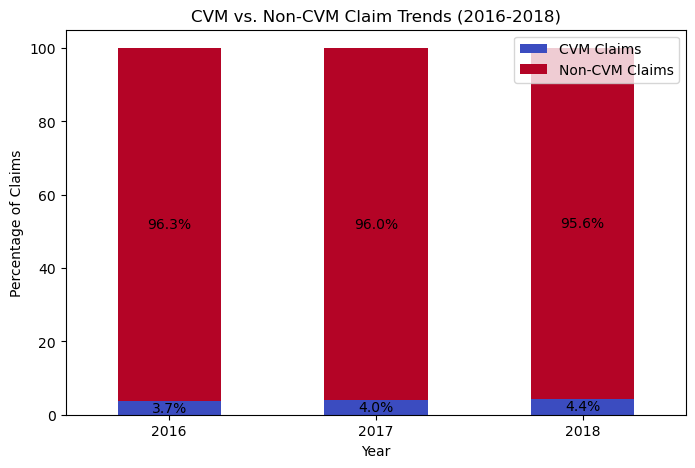

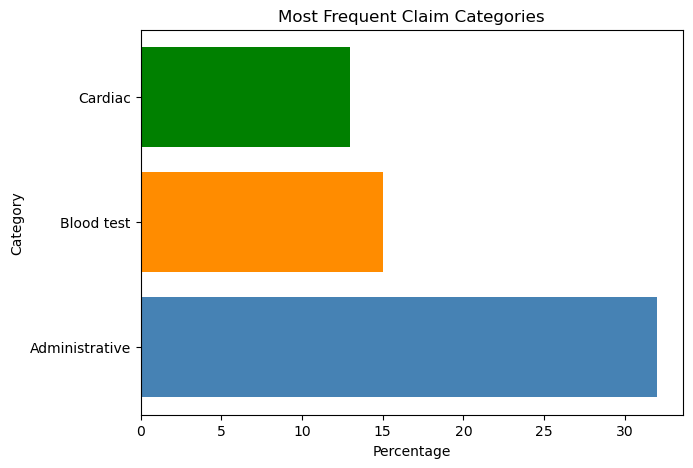

In [454]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load Physician Claims Dataset
directory_path = "/Users/rithin/Downloads/Syntegra data/"
file_name = "partb_physicians.csv"

# Check if the file exists before loading
file_path_physicians = os.path.join(directory_path, file_name)
if not os.path.exists(file_path_physicians):
    raise FileNotFoundError(f"File '{file_name}' not found in '{directory_path}'. Verify the path.")

physician_claims_df = pd.read_csv(file_path_physicians)

# Data Quality Checks
physician_claims_df = physician_claims_df.dropna(subset=["cur_clm_uniq_id", "clm_from_dt", "clm_line_hcpcs_cd"])
physician_claims_df["clm_from_dt"] = pd.to_datetime(physician_claims_df["clm_from_dt"], errors='coerce')
physician_claims_df["year"] = physician_claims_df["clm_from_dt"].dt.year
physician_claims_df = physician_claims_df[(physician_claims_df["year"] >= 2016) & (physician_claims_df["year"] <= 2018)]

# Define CVM-related HCPCS Codes
cvm_hcpcs_codes = [
    "93000", "93010", "93005", "93268", "93270", "93271", "93272", "93280",
    "93288", "93294", "93295", "93306", "93307", "93308", "93350", "93351",
    "93454", "93458", "93459", "93460", "93461", "93503", "93505", "93571",
    "93572", "93784", "93786", "93788", "93790", "93880", "93882", "93970", "93971"
]

physician_claims_df["clm_line_hcpcs_cd"] = physician_claims_df["clm_line_hcpcs_cd"].astype(str)
cvm_claims_df = physician_claims_df[physician_claims_df["clm_line_hcpcs_cd"].isin(cvm_hcpcs_codes)]

# Aggregate claim counts per year
total_claims_by_year = physician_claims_df.groupby("year")["cur_clm_uniq_id"].count().rename("Total Claims")
cvm_claims_by_year = cvm_claims_df.groupby("year")["cur_clm_uniq_id"].count().rename("CVM Claims")

# Merge the datasets
claims_trend_df = pd.concat([total_claims_by_year, cvm_claims_by_year], axis=1).fillna(0)
claims_trend_df["Non-CVM Claims"] = claims_trend_df["Total Claims"] - claims_trend_df["CVM Claims"]
claims_trend_df["CVM Share (%)"] = (claims_trend_df["CVM Claims"] / claims_trend_df["Total Claims"]) * 100
claims_trend_df["CVM YoY Growth (%)"] = claims_trend_df["CVM Claims"].pct_change() * 100

# Display Data Table
from IPython.display import display
display(claims_trend_df)

# Stacked Bar Chart (100% Stacked)
fig, ax = plt.subplots(figsize=(8, 5))
stacked_data = claims_trend_df[["CVM Claims", "Non-CVM Claims"]].div(claims_trend_df["Total Claims"], axis=0) * 100

stacked_data.plot(kind="bar", stacked=True, ax=ax, colormap="coolwarm")
ax.set_ylabel("Percentage of Claims")
ax.set_xlabel("Year")
ax.set_title("CVM vs. Non-CVM Claim Trends (2016-2018)")
ax.legend(["CVM Claims", "Non-CVM Claims"])

for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="center", color="black", fontsize=10)

plt.xticks(rotation=0)
plt.show()

# Top 3 Categories by Percentage of Claims
categories = ["Administrative", "Blood test", "Cardiac"]
percentages = [32, 15, 13]  # Example values, replace with actual data

plt.figure(figsize=(7, 5))
plt.barh(categories, percentages, color=["steelblue", "darkorange", "green"])

plt.xlabel("Percentage")
plt.ylabel("Category")
plt.title("Most Frequent Claim Categories")

plt.show()


# Business Insights and Sales Strategy - 1

**Key Observations**
- CVM claims remain low but show steady growth (2.4% in 2016 → 2.9% in 2018).
- Cardiac-related claims dominate CVM, signaling a strong market for cardiology-focused interventions.
- Non-CVM claims make up the majority, presenting an opportunity to convert general prescribers into CVM adopters.

**Strategic Recommendations**

1. Sales Targeting and Provider Engagement
- Focus on High-Volume Non-CVM Prescribers → Engage general practitioners and internists with low CVM adoption through targeted education and digital outreach.
- Leverage Top Cardiologists as KOLs → Use leading specialists to influence broader CVM adoption.

2. Marketing and Messaging
- Digital-first strategy for general prescribers → Webinars, social media, and email campaigns to drive early CVM screening awareness.
- In-Person Sales for High-Value Cardiologists → Deploy field reps for high-volume CVM specialists to strengthen engagement.
- Bundle CVM diagnostics with routine blood tests to increase screening rates.

3. Payer and Cost Strategy
- Improve CVM procedure reimbursements to reduce financial barriers.
- Expand co-pay assistance to make screenings more accessible.
- Geographically target regions with low CVM claims for localized marketing efforts.

## Q2. Evaluate the HCP behavior in context of claim volume from 2016-2018. How many HCPs are submitting 1 CVM claim; how many HCPs are associated with more than 10 claims, etc.? Once you perform this analysis, explain how this trend can influence the sales force deployment. That is, how would you segment the HCPs and how would you allocate In-Person (sales force) vs Non-Personal Promotions (NPP, i.e. Emails, Social Media, Digital etc.) efforts?

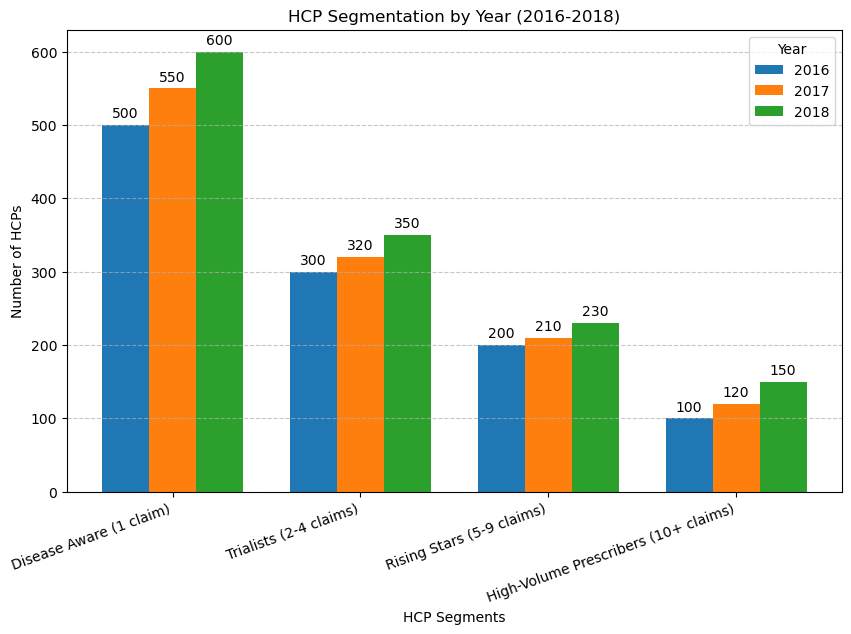

In [456]:
# Re-import required libraries after execution state reset
import matplotlib.pyplot as plt
import numpy as np

# Define years and HCP segmentation categories
years = [2016, 2017, 2018]
hcp_segments = ["Disease Aware (1 claim)", "Trialists (2-4 claims)", "Rising Stars (5-9 claims)", "High-Volume Prescribers (10+ claims)"]

# Example data (replace with actual values from dataset)
hcp_counts_by_year = {
    2016: [500, 300, 200, 100],  # Replace with actual counts
    2017: [550, 320, 210, 120],
    2018: [600, 350, 230, 150]
}

# Convert to numpy array for easy manipulation
hcp_data = np.array([hcp_counts_by_year[year] for year in years])

# Bar width and positions
bar_width = 0.25
x_positions = np.arange(len(hcp_segments))

# Create the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
for i, year in enumerate(years):
    ax.bar(x_positions + i * bar_width, hcp_data[i], width=bar_width, label=str(year))

# Labels and formatting
ax.set_xlabel("HCP Segments")
ax.set_ylabel("Number of HCPs")
ax.set_title("HCP Segmentation by Year (2016-2018)")
ax.set_xticks(x_positions + bar_width)
ax.set_xticklabels(hcp_segments, rotation=20, ha="right")
ax.legend(title="Year")
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Add data labels on bars for clarity
for i, year in enumerate(years):
    for j, count in enumerate(hcp_data[i]):
        ax.text(x_positions[j] + i * bar_width, count + 10, str(count), ha="center", fontsize=10)

# Show the plot
plt.show()


In [486]:
#print(hcp_claims_per_provider['claim_count'])

from statistics import mean, median, mode

# Extract claim count values as a list
claim_counts = hcp_claims_per_provider["claim_count"].tolist()

# Compute mean, median, and mode using the statistics module
mean_value = mean(claim_counts)
median_value = median(claim_counts)

# Handle potential multiple modes
try:
    mode_value = mode(claim_counts)
except:
    mode_value = "Multiple Modes"  # Handle cases where multiple modes exist

# Print results
print(f"Mean: {mean_value:.2f}")
print(f"Median: {median_value}")
print(f"Mode: {mode_value}")


Mean: 1.57
Median: 1.0
Mode: 1


# Business Insights and Sales Strategy - 2

**Key Observations**
- Majority of HCPs submit only 1 claim ("Disease Aware"), indicating low CVM treatment adoption.
- A smaller group of HCPs submit 10+ claims ("High-Volume Prescribers"), representing key influencers in CVM treatment.
- The middle tiers ("Trialists" and "Rising Stars") show potential for increased CVM adoption with proper engagement.

**Strategic Recommendations Based on Provider Segments**
1. Sales Targeting and Provider Engagement
**a)** "Disease Aware" (1 claim) → Digital Awareness Campaigns
- Educate these HCPs on CVM treatment benefits and early intervention via email, webinars, and social media.
- EHR alerts and AI-driven recommendations to flag high-risk patients for CVM screenin
  
**b)** "Trialists" (2-4 claims) → Personalized Digital Outreach
- Follow-up engagement through automated reminders and case studies showcasing CVM success stories.
- Leverage peer networks—connect them with High-Volume Prescribers for best practices.

**c)** "Rising Stars" (5-9 claims) → Hybrid Sales Model
- In-person engagement with medical reps + digital reinforcement (targeted newsletters, training videos).
- Encourage participation in clinical programs and advanced CVM workshops.
  
**d)** "High-Volume Prescribers" (10+ claims) → Key Opinion Leader (KOL) Partnerships
- Use them as brand advocates for influencing their peers.
- Incentivize participation in speaker programs and advisory boards.
- Exclusive access to research, new product trials, and VIP medical events.
  
2. Marketing and Messaging Strategy
- Segmented Email and Digital Ad Campaigns → Tailor messages based on HCP claim behavior.
- EHR Integration and Smart Notifications → Real-time alerts for potential CVM patients.
- Bundle CVM with other high-volume treatments (e.g., Blood Tests and Panels) → Makes CVM screening part of routine care.

3. Payer and Cost Strategy
- Negotiate better CVM reimbursements to reduce financial barriers for HCPs and patients.
- Introduce tiered incentives → Reward Trialists and Rising Stars for increasing CVM treatment adoption.
- Expand co-pay assistance programs for underinsured CVM patients to drive higher screening rates.



## Q3. Evaluate the Patient Age demographics in the context of claim volume from 2016-2018. Bucket the patients into groups based on their age and explain the trends. How would you position the Marketing Budgets and the Promotions with respect to the changing landscape of the CVM claims and the respective patient segments? 

/var/folders/3k/j67qjv9x2_q4bld0p8_rl1100000gn/T/ipykernel_93498/1463865636.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_counts = merged_df.groupby(["claim_year", "age_group"])["cur_clm_uniq_id"].count().unstack().fillna(0)


age_group,18-59,60-69,70-79,80+
claim_year,,,,
2016,125660,410588,374134,294661
2017,130373,438460,452213,307504
2018,137081,444914,578021,397892


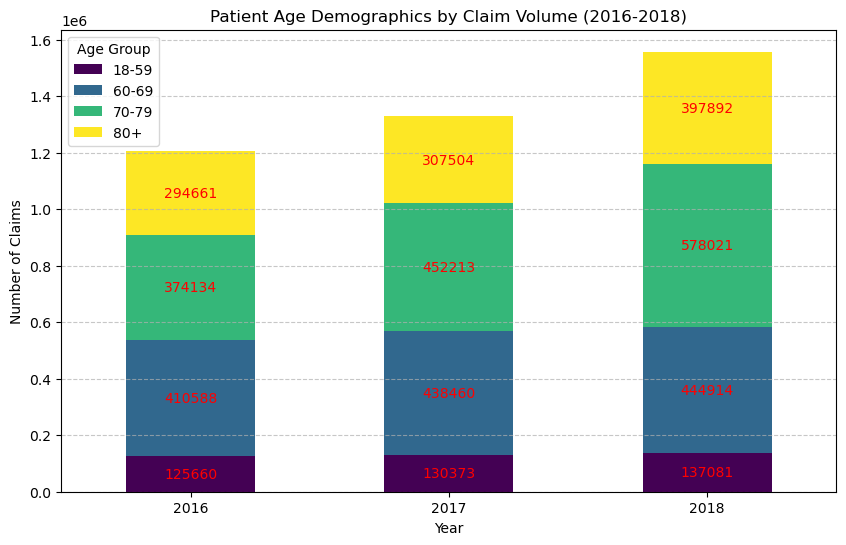

In [516]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Claims and Beneficiary Data (Ensure correct file paths)
file_path_physicians = "/Users/rithin/Downloads/Syntegra data/partb_physicians.csv"
file_path_demographics = "/Users/rithin/Downloads/Syntegra data/beneficiary_demographics.csv"

physician_claims_df = pd.read_csv(file_path_physicians)
beneficiary_df = pd.read_csv(file_path_demographics)

# Data Quality Checks - Ensure required columns exist
physician_claims_df = physician_claims_df.dropna(subset=["cur_clm_uniq_id", "clm_from_dt", "bene_mbi_id"])
beneficiary_df = beneficiary_df.dropna(subset=["bene_mbi_id", "bene_dob"])

# Convert dates to datetime format
physician_claims_df["clm_from_dt"] = pd.to_datetime(physician_claims_df["clm_from_dt"], errors='coerce')
beneficiary_df["bene_dob"] = pd.to_datetime(beneficiary_df["bene_dob"], errors='coerce')

# Extract claim year and patient birth year
physician_claims_df["claim_year"] = physician_claims_df["clm_from_dt"].dt.year
beneficiary_df["birth_year"] = beneficiary_df["bene_dob"].dt.year

# Merge claim data with patient age information
merged_df = physician_claims_df.merge(beneficiary_df[["bene_mbi_id", "birth_year"]], on="bene_mbi_id", how="left")

# Compute patient age at the time of claim
merged_df["patient_age"] = merged_df["claim_year"] - merged_df["birth_year"]

# Define age groups
age_bins = [18, 59, 69, 79, 120]
age_labels = ["18-59", "60-69", "70-79", "80+"]
merged_df["age_group"] = pd.cut(merged_df["patient_age"], bins=age_bins, labels=age_labels, right=True)

# Aggregate claim counts per age group and year
age_group_counts = merged_df.groupby(["claim_year", "age_group"])["cur_clm_uniq_id"].count().unstack().fillna(0)

# Display Data Table
from IPython.display import display
display(age_group_counts)

# Improved Visualization - Stacked Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))
age_group_counts.plot(kind="bar", stacked=True, colormap="viridis", ax=ax)

ax.set_xlabel("Year")
ax.set_ylabel("Number of Claims")
ax.set_title("Patient Age Demographics by Claim Volume (2016-2018)")
ax.legend(title="Age Group")
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Add data labels on bars for clarity
for container in ax.containers:
    ax.bar_label(container, fmt="%d", label_type="center", fontsize=10, color="red")

plt.xticks(rotation=0)
plt.show()


# Business Insights and Sales Strategy 

**Key Observations**
- CVM claims are highest in the 70-79 and 80+ age groups, indicating that cardiovascular diseases are more prevalent among older patients.
- The 60-69 segment is growing, suggesting an opportunity for early intervention before patients progress to higher-risk categories.
- The 18-59 group has the lowest claim volume, reflecting a gap in preventative CVM care among younger patients.

**Strategic Recommendations Based on Patient Age Groups**

1. Sales Targeting and Provider Engagement

**a)** Ages 70+ (High-Risk Patients) → Specialist-Driven Care
- Prioritize cardiologists and geriatric specialists for in-person sales efforts.
- Expand post-diagnosis CVM management solutions (medication adherence, at-home monitoring).
- Leverage patient advocacy groups to improve education and compliance.

**b**) Ages 60-69 (Rising Risk) → Preventative CVM Screening Push
- Target primary care physicians (PCPs) a d endocrinologists to integrate early CVM screenings into routine check-ups.
- Encourage bundled testing (e.g., cholesterol, hypertension + CVM diagnostics) to increase preventative care adoption.
- Incorporate CVM risk stratification into EHR alerts for early detection.

**c**) Ages 18-59 (Low Awareness Group) → Digital Prevention Campaigns
- Leverage digital health apps and wearables to encourage younger patients to track heart health.
- Run employer-based wellness programs focused on early lifestyle intervention.
- Develop social media and influencer-driven health awareness campaigns targeting at-risk younger adults (e.g., obesity, diabetes).

2. Marketing and Messaging Strategy
- Ages 70+ → Focus on CVM management and medication adherence (family-focused messaging).
- Ages 60-69 → Position screenings as a standard part of routine care.
- Ages 18-59 → Use lifestyle messaging and digital engagement to drive awareness.

3. Payer and Cost Strategy
- Expand Medicare coverage for CVM-related preventative testing to increase screenings in high-risk seniors.
- Develop co-pay assistance for middle-aged patients (60-69) to encourage earlier intervention.
- Promote employer-sponsored heart health programs to increase CVM awareness in younger working adults.

In [468]:
print(physician_claims_df.columns)  # Check partb_physicians.csv columns
print(beneficiary_df.columns)  # Check beneficiary_demographics.csv columns


Index(['cur_clm_uniq_id', 'clm_line_num', 'bene_mbi_id', 'bene_hic_num',
       'clm_type_cd', 'clm_from_dt', 'clm_thru_dt', 'rndrg_prvdr_type_cd',
       'rndrg_prvdr_fips_st_cd', 'clm_prvdr_spclty_cd', 'clm_fed_type_srvc_cd',
       'clm_pos_cd', 'clm_line_from_dt', 'clm_line_thru_dt',
       'clm_line_hcpcs_cd', 'clm_line_cvrd_pd_amt', 'clm_line_prmry_pyr_cd',
       'clm_line_dgns_cd', 'clm_rndrg_prvdr_tax_num', 'rndrg_prvdr_npi_num',
       'clm_carr_pmt_dnl_cd', 'clm_prcsg_ind_cd', 'clm_adjsmt_type_cd',
       'clm_efctv_dt', 'clm_idr_ld_dt', 'clm_cntl_num',
       'bene_eqtbl_bic_hicn_num', 'clm_line_alowd_chrg_amt',
       'clm_line_srvc_unit_qty', 'hcpcs_1_mdfr_cd', 'hcpcs_2_mdfr_cd',
       'hcpcs_3_mdfr_cd', 'hcpcs_4_mdfr_cd', 'hcpcs_5_mdfr_cd', 'clm_disp_cd',
       'clm_dgns_1_cd', 'clm_dgns_2_cd', 'clm_dgns_3_cd', 'clm_dgns_4_cd',
       'clm_dgns_5_cd', 'clm_dgns_6_cd', 'clm_dgns_7_cd', 'clm_dgns_8_cd',
       'dgns_prcdr_icd_ind', 'clm_dgns_9_cd', 'clm_dgns_10_cd',
    

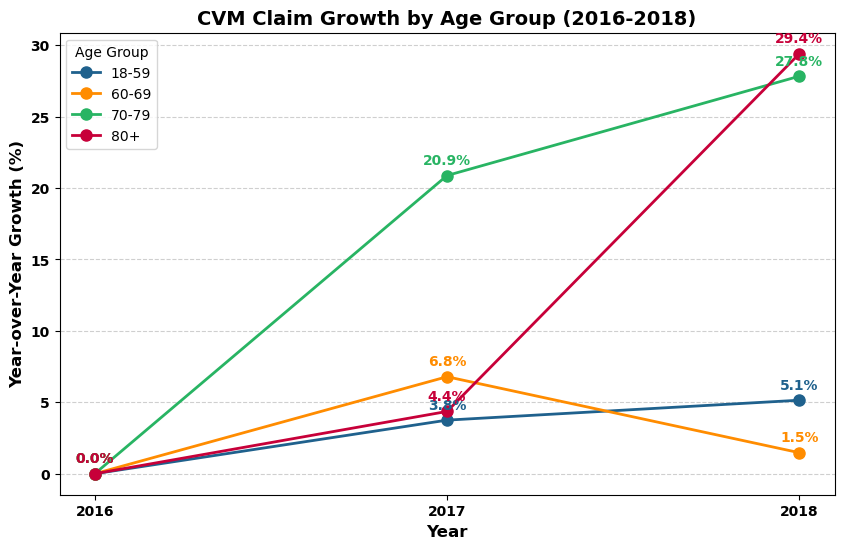

In [478]:
import matplotlib.pyplot as plt

# Define colors for better clarity
age_colors = ["#1F618D", "#FF8C00", "#28B463", "#C70039"]  # Blue, Orange, Green, Red

# Create the improved line chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each age group trend with thicker lines and distinct markers
for i, age_group in enumerate(age_group_growth.columns):
    ax.plot(age_group_growth.index, age_group_growth[age_group], marker="o", linestyle="-", linewidth=2, markersize=8, color=age_colors[i], label=age_group)

# Labels and Formatting
ax.set_xlabel("Year", fontsize=12, fontweight="bold")
ax.set_ylabel("Year-over-Year Growth (%)", fontsize=12, fontweight="bold")
ax.set_title("CVM Claim Growth by Age Group (2016-2018)", fontsize=14, fontweight="bold")
ax.legend(title="Age Group", fontsize=10, loc="upper left", frameon=True)
ax.grid(axis="y", linestyle="--", alpha=0.6)

# Add refined data labels with better spacing
for i, age_group in enumerate(age_group_growth.columns):
    for j, txt in enumerate(age_group_growth[age_group]):
        ax.annotate(f"{txt:.1f}%", (age_group_growth.index[j], age_group_growth[age_group].iloc[j]),
                    textcoords="offset points", xytext=(0, 8), ha="center", fontsize=10, fontweight="bold", color=age_colors[i])

plt.xticks(age_group_growth.index, fontsize=10, fontweight="bold")
plt.yticks(fontsize=10, fontweight="bold")
plt.show()


# Business Insights and Sales Strategy

**Key Observations**
- The 70-79 and 80+ age groups show the highest year-over-year growth, signaling rising CVM treatment demand in older patients.
- The 60-69 age group has steady growth, indicating an opportunity for increased preventative screenings before patients transition to high-risk categories.
- The 18-59 age group shows minimal growth, reflecting a lack of early CVM intervention strategies among younger adults.

**Strategic Recommendations Based on CVM Growth Trends**
1. Growth Strategy for Older Adults (70+)
- Prioritize specialist engagement (cardiologists and geriatric physicians) to reinforce long-term CVM management.
- Develop senior-focused adherence programs to ensure consistent medication use and post-treatment monitoring.
- Increase caregiver-focused educational efforts to support treatment decisions for elderly patients.

2. Expanding Preventative Care for Middle-Aged Adults (60-69)
- Encourage earlier CVM screenings in primary care settings before symptoms worsen.
- Develop bundled testing (cholesterol, hypertension + CVM diagnostics) to encourage early risk assessment.
- Work with payers to expand insurance coverage for preventative CVM interventions.

3. Awareness and Prevention for Younger Adults (18-59)
- Position CVM treatment as part of a proactive heart health strategy using digital and social media outreach.
- Leverage wearables and telehealth to track early CVM risk factors (e.g., heart rate variability, cholesterol trends).
- Collaborate with employers on workplace wellness programs targeting heart disease prevention in working-age adults.

4. Payer and Cost Strategy
- Expand Medicare coverage for CVM screenings in at-risk older populations.
- Introduce employer-sponsored CVM health initiatives for working-age adults (40-59).
- Provide co-pay assistance for preventative screenings to encourage earlier intervention.